# DOPP 24/25, Group 27, Exercise 2

In order to maintain some level of structure on that big notebook, we will be structuring it in the following sections:

* Introduction  
* Imports and constants
* Read-in function
* Dataset descriptions
* Missing data analysis
* Preprocessing functions
* Question 1 to 3

## OPEN POINTS / NEXT STEPS (TODO remove this section before submission)

More or less an ordered list.

* Should we exclude countries which are not part of the EU? Data is not available for those countries in a lot of cases AW: I (Domi) think that it is totally fine to only focus on the EU (Especially wit the given Questions.
  
* I noticed that some data cells in Excel contain no value, while some cells contain zero itself. In the data analysis / data description, I (Daniel) have assumed that zero and NaN do not mean the same. Data analysis also prints those cases separately. This is maybe not correct for all datasets, so better double-check the dataset before using it for question answering.


* When opening the 'data-sheets' in any excel file (all worksheets like Sheet1, Sheet, ...), there is always an additional column between 2 years. This the flag-column (e.g. :, b,d,u), which indicates e.g. the reliability of a concrete value and so on. The available special characters/flags are always listed after the actual data in the worksheet. I think that, depending on the time available for this project, it would be good to also read those columns in. That one is maybe not a top prio, but for a thorough analysis it can be very relevant to potentially also identify trends there.
* determine handling of missing values (imputing/removal?)
* For easier break-down, determine which datasets are relevant for which type of questions
* quick evaluation for ourselves: are we still convinced that we have enough data?
* write Introduction chapter


## Introduction
The adoption of renewable energy has become a corner stone of the european union in combating climate change and in ensuring long term sustainability. 
In the last decade, it is often claimed that Europe has made significant progress in the transition from fossil fuels to cleaner energy sources, driven by ambitious policies such as the European Green Deal, REPowerEU Plan, and the Fit-for-55 package. 

In this project our group has decided to use modern data science methodologies to investigate the following questions: 


1. How is the adoption of renewable energy in Europe evolving?
2. How is the adoption of different types of renewable energy evolving?
3. Are there characteristics of countries that correlate with their level of adoption of renewable energy?

## Imports and Constants

In [139]:
import seaborn
import warnings
from cycler import cycler

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import re
import json
import seaborn as sns

from functools import lru_cache

In [140]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl.styles.stylesheet")

In [141]:
# Share of energy from renewable sources                        
NRG_IND_REN = 'data/nrg_ind_ren_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_inf_epcrw__custom_13973000/default/table?lang=en
# Electricity production capacities for renewables and wastes
NRG_INF_EPCRW = 'data/nrg_inf_epcrw_spreadsheet.xlsx'           # https://ec.europa.eu/eurostat/databrowser/view/nrg_ind_ren/default/table?lang=en    
# Simplified energy balances           
NRG_BAL_S = 'data/nrg_bal_s__custom_13973102_spreadsheet.xlsx'  # https://ec.europa.eu/eurostat/databrowser/view/nrg_bal_s__custom_13973102/default/table?lang=en
# Supply and transformation of solid fossil fuels
NRG_CB_SFFM = 'data/nrg_cb_sffm_spreadsheet.xlsx'               # https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_sffm/default/table?lang=en 
# Electricity prices for household consumers          
NRG_PC_204 = 'data/nrg_pc_204_spreadsheet.xlsx'                 # https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_204/default/table?lang=en
# Population by educational attainment level, sex and age
EDAT_LFSE_03 = 'data/edat_lfse_03_spreadsheet.xlsx'             # https://ec.europa.eu/eurostat/databrowser/view/edat_lfse_03/default/table?lang=en
# Gross domestic product at market prices
TEC00001 = 'data/tec00001_page_spreadsheet.xlsx'                # https://ec.europa.eu/eurostat/databrowser/view/tec00001/default/table?lang=en

# Creating some 'groups'for a potential easier analysis by e.g.
# comparing just them to each other or comparing groups

EU_COUNTRIES = {
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark",
    "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal",
    "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
}

SCHENGEN_COUNTRIES = [
    "Austria", "Belgium", "Czechia", "Denmark", "Estonia", "Finland", "France", "Germany",
    "Greece", "Hungary", "Iceland", "Italy", "Latvia", "Liechtenstein", "Lithuania",
    "Luxembourg", "Malta", "Netherlands", "Norway", "Poland", "Portugal", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland"
]

CORE_ECONOMIES = ["Germany", "France", "Netherlands", "Austria", "Sweden", "Denmark"]

MEDITERRANEAN_ECONOMIES = ["Spain", "Italy", "Greece", "Portugal", "Malta", "Cyprus"]

EASTERN_GROWTH_ECONOMIES = ["Poland", "Czech Republic", "Hungary", "Slovakia", "Slovenia", "Croatia"]

GREEN_LEADERS = ["Sweden", "Denmark", "Finland", "Germany", "Netherlands"]

NORDIC_GREEN_LEADERS = ["Finland", "Sweden", "Denmark"]

PERIPHERAL_NATIONS = ["Bulgaria", "Romania", "Latvia", "Lithuania", "Estonia"]

EUROZONE_MEMBERS = [
    "Austria", "Belgium", "Cyprus", "Estonia", "Finland",
    "France", "Germany", "Greece", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta",
    "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"
]

NON_EUROZONE_MEMBERS = [
    "Bulgaria", "Croatia", "Czech Republic",
    "Denmark", "Hungary", "Poland", "Romania", "Sweden"
]

ENVIRONMENTAL_CHALLENGES = ["Bulgaria", "Romania", "Poland", "Hungary", "Greece"]

BALKAN_COUNTRIES = ["Bulgaria", "Romania", "Croatia", "Slovenia", "Greece"]

BENELUX_COUNTRIES = ["Belgium", "Netherlands", "Luxembourg"]

DIGITAL_LEADERS = ["Sweden", "Denmark", "Netherlands", "Finland", "Germany", "Estonia"]

DIGITAL_LAGGARDS = ["Bulgaria", "Romania", "Greece", "Croatia", "Slovakia"]

HIGHLY_URBANIZED = ["Belgium", "Netherlands", "Germany", "France", "Luxembourg"]

MODERATELY_URBANIZED = ["Spain", "Italy", "Poland", "Hungary", "Czech Republic"]

LOW_URBANIZED = ["Romania", "Bulgaria", "Latvia", "Lithuania", "Estonia"]

NET_CONTRIBUTORS = ["Germany", "France", "Netherlands", "Sweden", "Denmark", "Austria"]

NET_BENEFICIARIES = [
    "Poland", "Romania", "Hungary", "Greece",
    "Portugal", "Bulgaria", "Lithuania", "Latvia"
]

HIGH_RND_INVESTMENT = ["Sweden", "Finland", "Germany", "Netherlands", "Denmark"]

LOW_RND_INVESTMENT = ["Bulgaria", "Romania", "Greece", "Croatia", "Latvia"]

# TODO add or remove, those are the groups shown a sections down below when comparing the groups
def get_comparison_groups():
    all_entries = {}

    # Urbanization Levels
    # all_entries['URBANIZATION'] = {
    #     "highly_urbanized": HIGHLY_URBANIZED,
    #     "moderately_urbanized": MODERATELY_URBANIZED,
    #     "low_urbanized": LOW_URBANIZED
    # }

    # R&D Investment Levels
    all_entries['RND_INVESTMENT'] = {
        "high": HIGH_RND_INVESTMENT,
        "low": LOW_RND_INVESTMENT
    }

    # EU Budget Contributions
    all_entries['EU_BUDGET'] = {
        "net_contributors": NET_CONTRIBUTORS,
        "net_beneficiaries": NET_BENEFICIARIES
    }

    # Economic Groups
    #all_entries['ECONOMIC_GROUPS'] = {
    #    "core_economies": CORE_ECONOMIES,
    #    "mediterranean_economies": MEDITERRANEAN_ECONOMIES,
    #    "eastern_growth_economies": EASTERN_GROWTH_ECONOMIES
    #}

    # Environmental Factors
    all_entries['ENVIRONMENT'] = {
        "green_leaders": GREEN_LEADERS,
        "environmental_challenges": ENVIRONMENTAL_CHALLENGES
    }

    # Digital Transformation
    all_entries['DIGITAL_TRANSFORMATION'] = {
        "digital_leaders": DIGITAL_LEADERS,
        "digital_laggards": DIGITAL_LAGGARDS
    }

    # Regional Groups
    #all_entries['REGIONAL_GROUPS'] = {
    #    "balkan_countries": BALKAN_COUNTRIES,
    #    "benelux_countries": BENELUX_COUNTRIES
    #}

    # EU Membership Groups
    #all_entries['EU_MEMBERSHIP'] = {
    #    "eu_countries": list(EU_COUNTRIES),
    #    "schengen_countries": SCHENGEN_COUNTRIES,
    #    "eurozone_members": EUROZONE_MEMBERS,
    #    "non_eurozone_members": NON_EUROZONE_MEMBERS
    #}

    # Nordic and Peripheral Nations
    #all_entries['OTHER_GROUPS'] = {
    #    "nordic_green_leaders": NORDIC_GREEN_LEADERS,
    #    "peripheral_nations": PERIPHERAL_NATIONS
    #}

    return all_entries

## Functions for Read In & Dataset Statistics

In [142]:
@lru_cache
def eurostat_dataset(path: str) -> pd.DataFrame:

    # retrieve sheets data and metadata from Summary sheet
    ## the time frequency and unit of measurement information 
    # is not a relevant index value since they are always the same
    ignore = ['Time frequency', 'Unit of measure']
    summary = pd.read_excel(
        path, sheet_name='Summary', 
        usecols=lambda col: \
            not col.startswith('Unnamed') and col not in ignore,
        index_col='Contents', skiprows=14
    )

    all = []

    # iterate over data sheets and pre-process them
    for sheet_name, config in summary.iterrows():

        # the valuable information starts with the row containing "TIME" indicating the start of the data table
        preview = pd.read_excel(path, sheet_name=sheet_name, usecols=[0])
        header_row = preview[preview.iloc[:, 0] == 'TIME'].index[0]

        data = pd.read_excel(
            path, sheet_name=sheet_name,
            usecols= lambda col: not str(col).startswith('Unnamed'),
            na_values=':', skiprows=header_row + 1
        )

        # Remove the first row "Geo (Label)"
        data = data.iloc[1:].reset_index(drop=True)

        # some sheets contain additional meta-data at the end which are seperated by a NaN value row from the actual data
        ## if we find such a row we remove all rows after
        first_blank_row_index = data.isnull().all(axis=1).idxmax() if data.isnull().all(axis=1).any() else None
        if first_blank_row_index is not None:
            data = data.loc[:first_blank_row_index - 1]

        # rename TIME to country
        data.rename(columns={'TIME': 'Country'}, inplace=True)

        # create multi-index based on config
        config_df = pd.DataFrame([config] * len(data), index=data.index)
        data = pd.concat([config_df, data], axis=1)
        data.set_index(['Country'] + list(config_df.columns), inplace=True)

        all.append(data)

    # merge them into one multi-index data frame 
    all = pd.concat(all).sort_index()
    
    return all

In [143]:
def _analyse_zeros_and_nans_in_dataframe(df: pd.DataFrame, label: str):

    # Exclude index columns from analysis
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    total_columns = len(df_columns_only.columns)

    # Columns with at least one NaN value
    nan_any_columns = df_columns_only.columns[df_columns_only.isna().any()].tolist()
    nan_any_percentage = len(nan_any_columns) / total_columns * 100

    # Columns with only NaN values
    nan_only_columns = df_columns_only.columns[df_columns_only.isna().all()].tolist()
    nan_only_percentage = len(nan_only_columns) / total_columns * 100

    # Columns with at least one 0 value
    zero_any_columns = df_columns_only.columns[(df_columns_only == 0).any()].tolist()
    zero_any_percentage = len(zero_any_columns) / total_columns * 100

    # Columns with only 0 values
    zero_only_columns = df_columns_only.columns[(df_columns_only == 0).all()].tolist()
    zero_only_percentage = len(zero_only_columns) / total_columns * 100

    # Percentage of NaN values per column
    nan_percentage_per_column = df_columns_only.isna().mean() * 100
    nan_columns_above_50 = nan_percentage_per_column[nan_percentage_per_column > 50].to_dict()

    # Percentage of 0 values per column
    zero_percentage_per_column = (df_columns_only == 0).mean() * 100
    zero_columns_above_50 = zero_percentage_per_column[zero_percentage_per_column > 50].to_dict()

    # Generate a print statement for the analysis
    print(f"\n  Total columns analyzed: {total_columns}")
    print(f"  Columns with at least one NaN value: {len(nan_any_columns)} ({nan_any_percentage:.2f}%); {_transform_years_list_to_range(nan_any_columns)}")

    print(f"  Columns with only NaN values: {len(nan_only_columns)} ({nan_only_percentage:.2f}%); {_transform_years_list_to_range(nan_only_columns)}")

    print(f"  Columns with at least one 0 value: {len(zero_any_columns)} ({zero_any_percentage:.2f}%); {_transform_years_list_to_range(zero_any_columns)}")

    print(f"  Columns with only 0 values: {len(zero_only_columns)} ({zero_only_percentage:.2f}%); {_transform_years_list_to_range(zero_only_columns)}")

    print(f"  Columns with >50% NaN values:")
    for col, perc in nan_columns_above_50.items():
        print(f"    {col}: {perc:.2f}%")
    print(f"  Columns with >50% 0 values:")
    for col, perc in zero_columns_above_50.items():
        print(f"    {col}: {perc:.2f}%")


def _plot_eu_vs_other_missing_data_by_time(df, label):

    # Reset index to work with columns only
    df_columns_only = df.reset_index().iloc[:, len(df.index.names):]

    # Split into EU and non-EU DataFrames
    df_eu = df[df.index.get_level_values('Country').isin(EU_COUNTRIES)]
    df_non_eu = df[~df.index.get_level_values('Country').isin(EU_COUNTRIES)]

    # Missing values by time period for EU countries
    missing_per_time_eu = df_eu.isna().mean() * 100

    # Missing values by time period for non-EU countries
    missing_per_time_non_eu = df_non_eu.isna().mean() * 100

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # EU Plot
    axes[0].bar(missing_per_time_eu.index, missing_per_time_eu.values, color='blue', alpha=0.7)
    axes[0].set_title(f'{label}: Missing Data by Time Period (EU Countries)')
    axes[0].set_xlabel('Time Periods')
    axes[0].set_ylabel('Percentage of Missing Data')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)

    # Non-EU Plot
    axes[1].bar(missing_per_time_non_eu.index, missing_per_time_non_eu.values, color='green', alpha=0.7)
    axes[1].set_title(f'{label}: Missing Data by Time Period (Non-EU Countries)')
    axes[1].set_xlabel('Time Periods')
    axes[1].set_ylabel('Percentage of Missing Data')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()


def _plot_eu_vs_other_partially_missing_data_by_time(df, label):

    # Reset index to work with 'Country' column
    df_reset = df.reset_index()

    # Split into EU and non-EU DataFrames
    df_eu = df_reset[df_reset['Country'].isin(EU_COUNTRIES)]
    df_non_eu = df_reset[~df_reset['Country'].isin(EU_COUNTRIES)]

    # Analyze partial NaN columns for EU countries
    nan_percentage_eu = df_eu.isna().mean() * 100
    partial_nan_columns_eu = nan_percentage_eu[(nan_percentage_eu > 0) & (nan_percentage_eu < 100)]

    # Analyze partial NaN columns for non-EU countries
    nan_percentage_non_eu = df_non_eu.isna().mean() * 100
    partial_nan_columns_non_eu = nan_percentage_non_eu[(nan_percentage_non_eu > 0) & (nan_percentage_non_eu < 100)]

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Total width 12, each plot width 6

    # Visualization for EU countries
    axes[0].bar(partial_nan_columns_eu.index, partial_nan_columns_eu.values, alpha=0.7, color='blue')
    axes[0].set_title(f'{label}: Partial NaN Data (EU Countries)')
    axes[0].set_xlabel('Column Names')
    axes[0].set_ylabel('Percentage of NaN Data')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)

    # Visualization for non-EU countries
    axes[1].bar(partial_nan_columns_non_eu.index, partial_nan_columns_non_eu.values, alpha=0.7, color='green')
    axes[1].set_title(f'{label}: Partial NaN Data (Non-EU Countries)')
    axes[1].set_xlabel('Column Names')
    axes[1].set_ylabel('Percentage of NaN Data')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)

    # Adjust layout
    plt.tight_layout()
    plt.show()


def _transform_years_list_to_range(years: list) -> str:

    if not years:
        return ""

    years = [int(year) for year in years]

    years = sorted(years)
    ranges = []
    start = years[0]
    end = years[0]

    for i in range(1, len(years)):
        if years[i] == years[i - 1] + 1:
            end = years[i]
        else:
            if start == end:
                ranges.append(f"{start}")
            else:
                ranges.append(f"{start}-{end}")
            start = end = years[i]

    # Add the final range
    if start == end:
        ranges.append(f"{start}")
    else:
        ranges.append(f"{start}-{end}")

    return ", ".join(ranges)


def _analyse_country_specific_statistics(df: pd.DataFrame):

    # 1. Report the timeframe
    years = [col for col in df.columns]  # Assuming all columns are years
    earliest_year = min(years)
    latest_year = max(years)
    print(f"\nTimeframe of the dataframe: {earliest_year} to {latest_year}")

    # 2. Report if there are years with no data at all
    near_zero_columns = df[years].sum(axis=0).abs() < 1e-6
    no_data_years = [year for year, is_zero in near_zero_columns.items() if is_zero]
    if no_data_years:
        print(f"Years with no data at all: {no_data_years}")
    else:
        print("All years have significant data.")

    # 3. Report countries with values near zero in all years
    country_names = df.index.get_level_values(0).unique()  # Extract country names from the first level of the index
    country_sums = df.groupby(level=0)[years].sum()  # Sum over all sub-levels for each country
    near_zero_countries = country_sums.sum(axis=1).abs() < 1e-6
    zero_data_countries = country_sums.index[near_zero_countries].tolist()
    if zero_data_countries:
        print(f"Countries with near-zero values in all years: {zero_data_countries}")
    else:
        print("All countries have significant data.")

    # 4. List missing years for countries with partially missing data
    partially_missing_data = {}
    for country, row in country_sums.iterrows():
        missing_years = [year for year in years if abs(row[year]) < 1e-6 and year not in no_data_years]
        if missing_years and len(missing_years) < len(years):
            partially_missing_data[country] = missing_years

    if partially_missing_data:
        if no_data_years:
            print(f"\nCountries with partially missing years (except {no_data_years}, because no data for that year at all):")
        else:
            print(f"\nCountries with partially missing years:")
        for country, missing_years in partially_missing_data.items():
            print(f"  {country}: {_transform_years_list_to_range(missing_years)}")
    else:
        print("No countries have partially missing years.")

    # 5. EU vs non-EU analysis
    eu_in_df = EU_COUNTRIES.intersection(country_sums.index)
    non_eu_in_df = set(country_sums.index).difference(EU_COUNTRIES)
    missing_eu_countries = EU_COUNTRIES.difference(country_sums.index)

    if missing_eu_countries:
        print(f"EU countries missing in the dataframe: {sorted(missing_eu_countries)}")
    else:
        print("All EU countries are in the dataframe.")

    if non_eu_in_df:
        print(f"Non-EU countries in the dataframe: {sorted(non_eu_in_df)}")
    else:
        print("No non-EU countries are in the dataframe.")

    # 6. Comparison of missing data: EU vs non-EU
    def calculate_missing_percentage(countries):
        subset = df.loc[list(countries)]
        total_cells = subset.size
        missing_cells = subset.isna().sum().sum()
        return (missing_cells / total_cells) * 100 if total_cells > 0 else 0

    def calculate_zeros_percentage(countries):
        subset = df.loc[list(countries)]
        total_cells = subset.size
        missing_cells = (subset.abs() < 1e-6).sum().sum()
        return (missing_cells / total_cells) * 100 if total_cells > 0 else 0

    eu_zero_percentage = calculate_zeros_percentage(eu_in_df)
    non_eu_zero_percentage = calculate_zeros_percentage(non_eu_in_df)

    print(f"\nPercentage of zero-values in EU countries: {eu_zero_percentage:.2f}%")
    print(f"Percentage of zero-values in non-EU countries: {non_eu_zero_percentage:.2f}%")

    eu_missing_percentage = calculate_missing_percentage(eu_in_df)
    non_eu_missing_percentage = calculate_missing_percentage(non_eu_in_df)

    print(f"Percentage of missing data (NaN's) in EU countries: {eu_missing_percentage:.2f}%")
    print(f"Percentage of missing data (NaN's) in non-EU countries: {non_eu_missing_percentage:.2f}%")


def analyze_dataframe(df, label):
    """
    Orchestrates the overall analysis of the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        label (str):

    Returns:
        dict: A dictionary with results from all analyses.
    """
    print(f"### Running Data Analysis for dataset '{label}' ###")
    _analyse_zeros_and_nans_in_dataframe(df, label)
    _analyse_country_specific_statistics(df)
    data_quality_results = _plot_eu_vs_other_missing_data_by_time(df, label)
    country_level_results = _plot_eu_vs_other_partially_missing_data_by_time(df, label)

def _plot_eu_subset_filtered(df: pd.DataFrame, col: str, value: str, title_label: str, group1: list, group2: list):
    if col not in df.index.names and col is not None:
        raise ValueError(f"'{col}' is not part of the index")

    filtered_df = df.xs(value, level=col) if col is not None else df

    yearly_columns = [col for col in df.columns if col.isdigit()]

    if not yearly_columns:
        raise ValueError("No yearly columns found")

    # Initialize the plot
    plt.figure(figsize=(10, 7))

    all_years = list(map(str, sorted(map(int, yearly_columns))))

    # Plot Group 1
    for country in group1:
        if country in filtered_df.index.get_level_values('Country'):
            country_data = filtered_df.loc[(country, ), yearly_columns].reindex(all_years, axis=1, fill_value=float('nan'))
            plt.plot(
                country_data.columns,
                country_data.values.flatten(),
                linestyle='-',
                marker='s',
                label=f"Group 1: {country}",
                linewidth=2
            )

    # Plot Group 2
    for country in group2:
        if country in filtered_df.index.get_level_values('Country'):
            country_data = filtered_df.loc[(country, ), yearly_columns].reindex(all_years, axis=1, fill_value=float('nan'))
            plt.plot(
                country_data.columns,
                country_data.values.flatten(),
                linestyle='--',
                marker='o',
                label=f"Group 2: {country}",
                linewidth=2
            )

    # Add titles and labels
    plt.title(f"Yearly Data for {value} across: {title_label}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(title="Countries", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


def plot_comparison_groups(df: pd.DataFrame, col: str, value: str):

    groups = get_comparison_groups()

    for group_name, group_dict in groups.items():
        subgroup_names = list(group_dict.keys())

        # Pair subgroups for comparison if there are at least two subgroups
        for i in range(len(subgroup_names) - 1):
            for j in range(i + 1, len(subgroup_names)):
                subgroup1_name = subgroup_names[i]
                subgroup2_name = subgroup_names[j]

                countries1 = group_dict[subgroup1_name]
                countries2 = group_dict[subgroup2_name]

                # Combine countries into a filtered DataFrame
                df_filtered = df[df.index.get_level_values('Country').isin(countries1 + countries2)]

                # Plot the data for the two subgroups
                _plot_eu_subset_filtered(
                    df_filtered, col, value,
                    f"{group_name}: {subgroup1_name} vs {subgroup2_name}",
                    group1=countries1,
                    group2=countries2
                )

## Preprocessing functions

In [144]:
# preprocessing functions
def subset_to_eu_countries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a subset of the DataFrame containing only EU countries.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a multi-level index or a column labeled 'Country'.

    Returns:
        pd.DataFrame: A DataFrame containing only rows corresponding to EU countries.
    """
    if "Country" in df.index.names:
        # If 'Country' is part of the multi-index
        return df[df.index.get_level_values("Country").isin(EU_COUNTRIES)]
    elif "Country" in df.columns:
        # If 'Country' is a regular column
        return df[df["Country"].isin(EU_COUNTRIES)]
    else:
        raise ValueError("The DataFrame must have 'Country' as an index level or a column.")

def transform_special_characters_to_nan(df: pd.DataFrame, chars: list) -> pd.DataFrame:
    # Replace specified values with NaN
    transformed_df = df.replace(chars, np.nan)
    return transformed_df

def transform_df_from_monthly_to_yearly(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Identify columns with names in the format 'YYYY-MM'
    monthly_columns = [col for col in df_new.columns if re.match(r"^\d{4}-\d{2}$", str(col))]

    # Group monthly columns by year
    year_groups = {}
    for col in monthly_columns:
        year = col.split('-')[0]  # Extract the year
        if year not in year_groups:
            year_groups[year] = []
        year_groups[year].append(col)

    # Sum monthly values into yearly totals
    for year, columns in year_groups.items():
        df_new[year] = df_new[columns].sum(axis=1)  # Create a new column for the yearly total
        df_new.drop(columns, axis=1, inplace=True)  # Remove the monthly columns

    return df_new

def sum_over_index_level(df: pd.DataFrame, level: str) -> pd.DataFrame:
    # Sum over the specified level
    return df.groupby(level=[lvl for lvl in df.index.names if lvl != level]).sum()

def transform_df_from_semesterly_to_yearly(df: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Identify columns with names in the format 'YYYY-SX'
    semesterly_columns = [col for col in df_new.columns if re.match(r"^\d{4}-S[12]$", str(col))]

    # Group semesterly columns by year
    year_groups = {}
    for col in semesterly_columns:
        year = col.split('-')[0]  # Extract the year
        if year not in year_groups:
            year_groups[year] = []
        year_groups[year].append(col)

    # Sum semesterly values into yearly totals
    for year, columns in year_groups.items():
        df_new[year] = df_new[columns].sum(axis=1)  # Create a new column for the yearly total
        df_new.drop(columns, axis=1, inplace=True)  # Remove the semesterly columns

    return df_new

## Dataset Descriptions

### File Structures

Each of the 6 Excel-files contains two standardized worksheets for metadata, namely 'Summary' and 'Structure', and the actual data contained in that file is split across the (multiple) other worksheets.

* 'Summary' contains some metadata (e.g. short description,links), plus a list of additional worksheets where the actual data is contained. Each entry in that list consists at least of the worksheet-name, the unit of measure and the time frequency (always annual?), plus some file-specific columns.
* 'Structure' contains the descriptions (e.g., Germany is a geopolitical entity, or Exports is of dimension Energy Balance) for all dimensions mentioned in that Excel file. It is however not directly relevant when reading in the data for this project and also not processed.
* All other sheets (all of them contain actual data) have some kind of header (around 10 rows), then the actual data, and afterwards maybe some additional stuff (e.g. flag explanation). The actual data is always the same: Country as a row, value for a given year OR year+month as column.

### Dataset 1: Population by educational attainment level, sex and age


TODO do we even need this dataset? potentially remove at the before submission if not needed. AW:Domi Could be interesting for the 3. Question and the correlations

**Unit of measure**: Percentage (e.g., in 1995, 41.4% of Austrian Females between 15 and 64 had education level 0-2, while 5.9% had education level 5-8 and 52.7% had level 3-4) TODO is that correct?

**Available years in the dataset**: 1992-2023

**Time:** Annually

**This dataframe is multi-indexed by those 4 columns**:
- Country
- Sex (Total, Males, Females)
- Age class (a lot of different areas, all equal to or in between 15 and 64) TODO preprocess column
- Level of education TODO preprocess column


**Available flags**:

* (:) - not available
* (b) - break in time series
* (u) - low reliability
* (bu) - break in time series, low reliability

In [145]:
'''
COMMENTED OUT BECAUSE IT TAKES VERY LONG TO LOAD AND IS MAYBE NOT NEEDED

df_population_by_education_sex_age = eurostat_dataset(EDAT_LFSE_03)
label_df_population_by_education_sex_age = 'Population by educational, sex and age'
df_population_by_education_sex_age.head(15)
'''

"\nCOMMENTED OUT BECAUSE IT TAKES VERY LONG TO LOAD AND IS MAYBE NOT NEEDED\n\ndf_population_by_education_sex_age = eurostat_dataset(EDAT_LFSE_03)\nlabel_df_population_by_education_sex_age = 'Population by educational, sex and age'\ndf_population_by_education_sex_age.head(15)\n"

In [146]:
#analyze_dataframe(df_population_by_education_sex_age, label_df_population_by_education_sex_age)

### Dataset 2: Simplified energy balances

**Unit of measure** Gigawatt-hours (GWh) (e.g., in 1990, Albanias Total Energy supply was 31086.839 GWh)

**Available years in the dataset**: 1990-2023

**Time:** Annually


One can see the annually aggregated values of various **energy balances structured by the following multi-level index**:
- Country
- Energy balance, which is either
    * Available for final consumption
    * Gross available energy
    * Primary energy consumption (Europe 2020-2023) (this one was removed, as there are a lot of NaN's for a lot of countries)
    * Total energy supply

(The column 'Standard international energy product classification (SIEC)' always contains the value 'Total' and will therefore be removed.)

**Available flags:**

* : - not available

In [147]:
df_energy_balances_by_country = eurostat_dataset(NRG_BAL_S)
label_df_energy_balances_by_country = 'Energy Balances by country'

# remove index column 'Standard international energy product classification (SIEC)'
df_reset = df_energy_balances_by_country.reset_index().drop(columns=['Standard international energy product classification (SIEC)'])

# filter out the rows for 'Primary energy consumption (Europe 2020-2030)'
df_filtered = df_reset[df_reset['Energy balance'] != 'Primary energy consumption (Europe 2020-2030)']
df_energy_balances_by_country = df_filtered.set_index(['Country', 'Energy balance'])

df_energy_balances_by_country = df_energy_balances_by_country.rename_axis(index={'Energy balance': 'energy_balance'})
df_energy_balances_by_country.head(15)

1990  \
Country                energy_balance                                
Albania                Available for final consumption   25468.502   
                       Gross available energy            31086.839   
                       Total energy supply               31086.839   
Austria                Available for final consumption  227893.897   
                       Gross available energy           294766.068   
                       Total energy supply              291185.346   
Belgium                Available for final consumption  360837.846   
                       Gross available energy           614412.772   
                       Total energy supply              555608.216   
Bosnia and Herzegovina Available for final consumption         NaN   
                       Gross available energy                  NaN   
                       Total energy supply                     NaN   
Bulgaria               Available for final consumption   203243.14   
                       Gross available energy               328661   
                       Total energy supply              325156.889   

                                                              1991  \
Country                energy_balance                                
Albania                Available for final consumption   17375.307   
                       Gross available energy            21758.512   
                       Total energy supply               21758.512   
Austria                Available for final consumption  244309.138   
                       Gross available energy           313485.830   
                       Total energy supply              309504.886   
Belgium                Available for final consumption  384674.143   
                       Gross available energy           640104.577   
                       Total energy supply              580739.882   
Bosnia and Herzegovina Available for final consumption         NaN   
                       Gross available energy                  NaN   
                       Total energy supply                     NaN   
Bulgaria               Available for final consumption  151071.041   
                       Gross available energy           266599.500   
                       Total energy supply              260364.888   

                                                              1992  \
Country                energy_balance                                
Albania                Available for final consumption   12569.078   
                       Gross available energy            15796.031   
                       Total energy supply               15796.031   
Austria                Available for final consumption  238581.580   
                       Gross available energy           301327.038   
                       Total energy supply              297043.038   
Belgium                Available for final consumption  395572.582   
                       Gross available energy           646297.818   
                       Total energy supply              587758.095   
Bosnia and Herzegovina Available for final consumption         NaN   
                       Gross available energy                  NaN   
                       Total energy supply                     NaN   
Bulgaria               Available for final consumption  126475.644   
                       Gross available energy           244441.248   
                       Total energy supply              237594.081   

                                                              1993  \
Country                energy_balance                                
Albania                Available for final consumption   11468.949   
                       Gross available energy            15480.885   
                       Total energy supply               15480.885   
Austria                Available for final consumption  242053.195   
                       Gross available energy           305054.609   

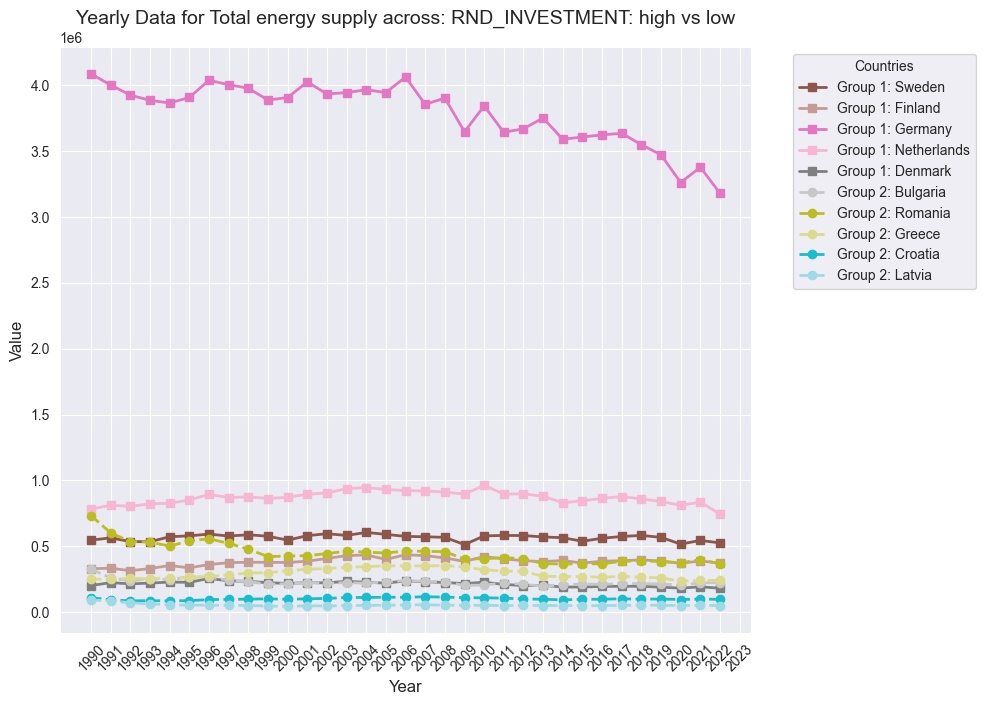

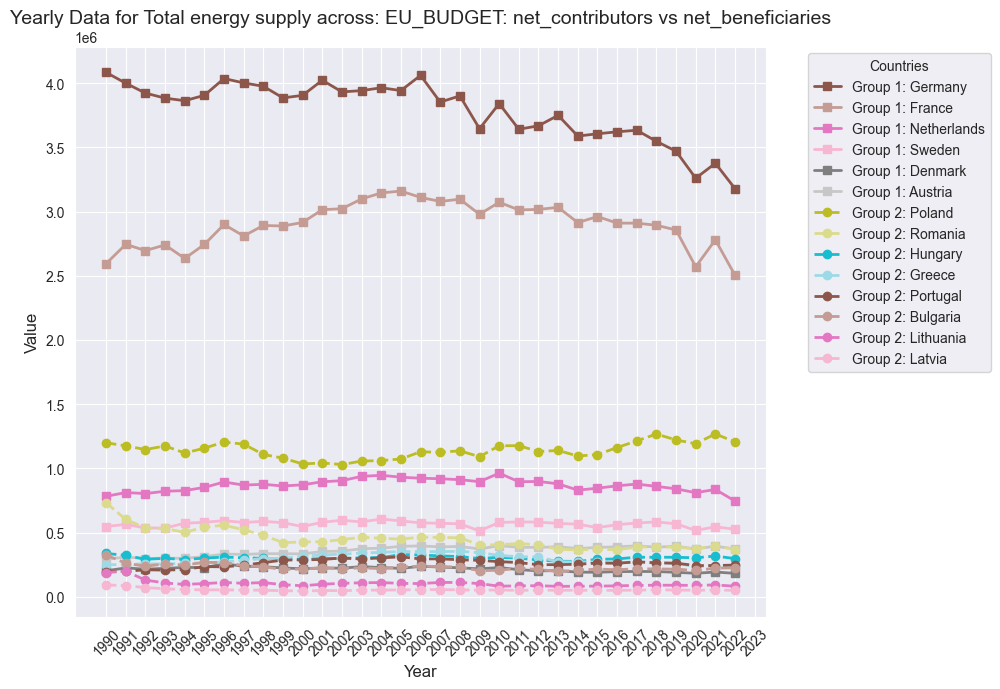

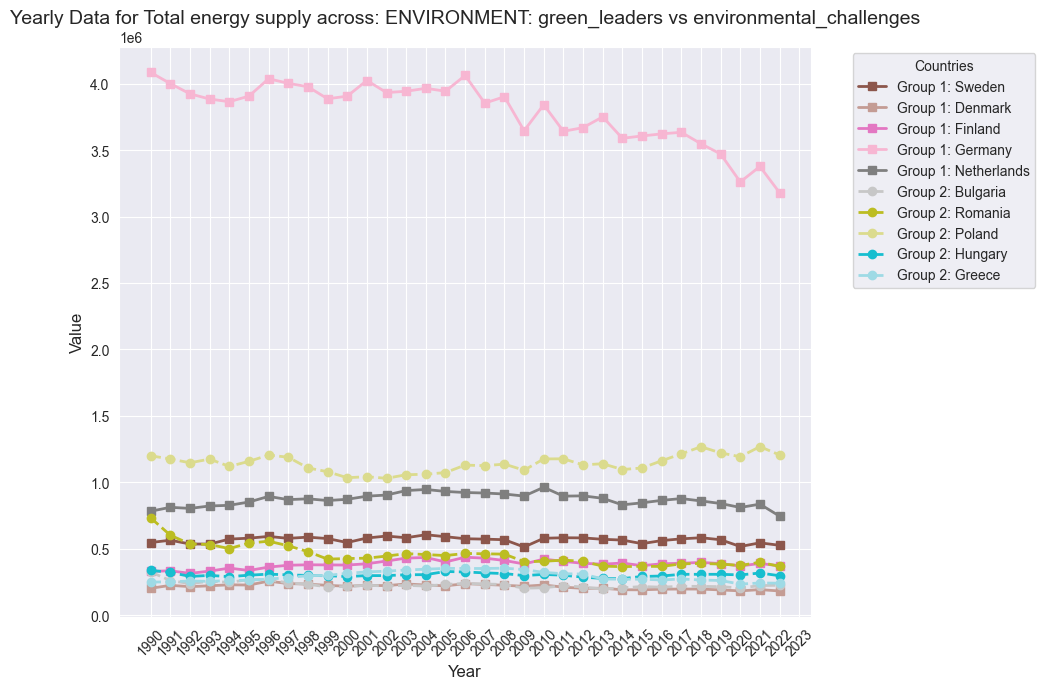

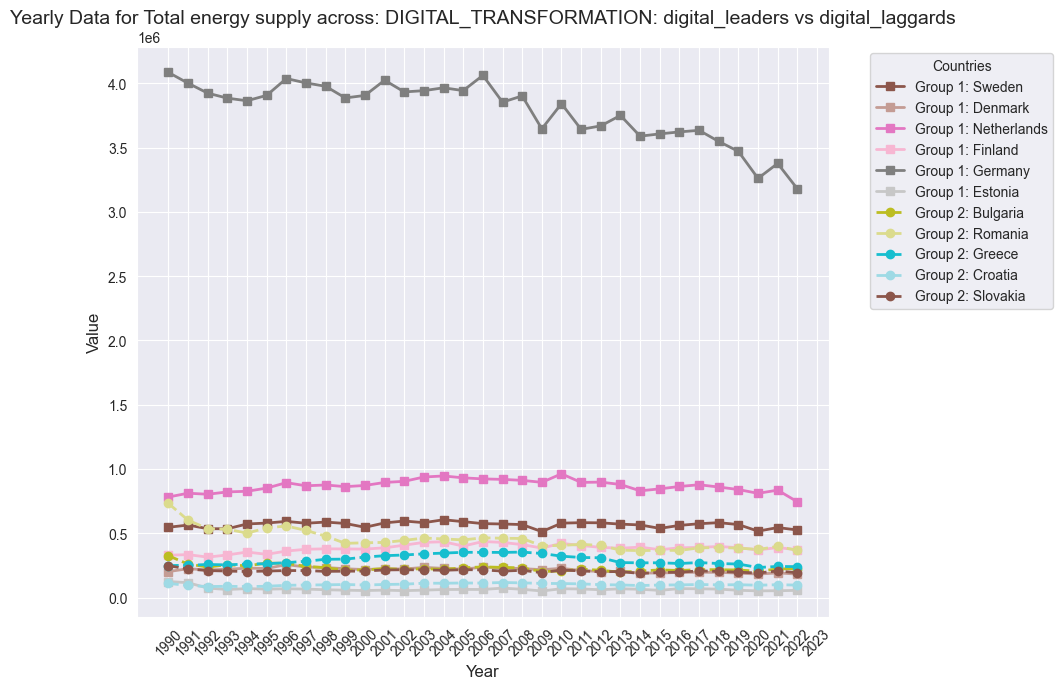

In [148]:
plot_comparison_groups(df_energy_balances_by_country, 'energy_balance', 'Total energy supply')

### Dataset 3: Supply and transformation of solid fossil fuels

**Unit of measure**: Thousand tonnes TODO how to exactly interpret this? AW:Domi what do you mean? Do you mean units? It would go for kT (kiloTons)


**Available years in the data**: 2008-2024

**Time**: Monthly, but converted to annually down below

**Multi-Level-Index is currently the following:**

* Country

* 'Standard international energy product classification (SIEC)', which can be:
    * Hard coal
    * Brown coal
    * Coke oven coke
    * Peat
    * Oil shale and oil sands

TODO is 'Energy balance' below relevant for us? In case it is, change code below as I sum up over this column and remove it
(
* 'Energy balance', which can be:
    * Indigenous production
    * Recovered and recycled products
    * Imports
    * Imports from outside EU
    * Exports
    * Opening stocks on national territory
    * Closing stocks on national territory
    * Change in stock
    * Gross inland deliveries - calculated
    * Gross inland deliveries - observed
    * Transformation input - electricity and heat generation - main activity producers
    * Transformation input - coke ovens
    * Final consumption - industry sector
    * Final consumption - industry sector - iron and steel
    * Final consumption - other sectors
    * Statistical differences)

**Available flags:**
* : -	not available
* bn -	break in time series, not significant
* b -	break in time series
* e -	estimated
* n -	not significant
* p -	provisional
* TODO except the flag ':', the flags have been in different columns than the values (an additional one next to the month-column) and are therefore currently not available! Should we add them? How much do we care about the various flags?

In [149]:
df_fossil_fuels_monthly_data = eurostat_dataset(NRG_CB_SFFM)
df_fossil_fuels_yearly_data = transform_df_from_monthly_to_yearly(df_fossil_fuels_monthly_data)
df_fossil_fuels = sum_over_index_level(df_fossil_fuels_yearly_data, 'Energy balance')
label_df_fossil_fuels = 'Fossil fuels by country'

df_fossil_fuels = df_fossil_fuels.rename_axis(index={'Standard international energy product classification (SIEC)': 'energy_product'})
df_fossil_fuels.head(15)

2008     2009     2010     2011     2012  \
Country energy_product                                                         
Albania Brown coal                     0      0.0      0.0      0.0      0.0   
        Coke oven coke                 0      0.0      0.0      0.0      0.0   
        Hard coal                      0      0.0      0.0      0.0      0.0   
        Oil shale and oil sands        0      0.0      0.0      0.0      0.0   
        Peat                           0      0.0      0.0      0.0      0.0   
Austria Brown coal                  94.0     50.0     60.0     76.0     52.0   
        Coke oven coke            7734.0   5953.0   7659.0   7819.0   7997.0   
        Hard coal                44385.0  53441.0  64746.0  52536.0  48900.0   
        Oil shale and oil sands        0      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0      0.0   
Belgium Brown coal                   0.0      0.0      0.0    605.0    578.0   
        Coke oven coke           19227.0  14496.0   7570.0  10711.0   9806.0   
        Hard coal                37164.0  27579.0   3791.0  41988.0  34383.0   
        Oil shale and oil sands        0      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0      0.0   

                                    2013     2014     2015     2016  \
Country energy_product                                                
Albania Brown coal                   0.0      0.0      0.0      0.0   
        Coke oven coke               0.0      0.0      0.0      0.0   
        Hard coal                    0.0      0.0      0.0      0.0   
        Oil shale and oil sands      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0   
Austria Brown coal                 166.0    188.0    136.0    134.0   
        Coke oven coke            9941.0   8289.0   8304.0   8215.0   
        Hard coal                47695.0  44629.0  37001.0  26634.0   
        Oil shale and oil sands      0.0      0.0      0.0      0.0   
        Peat                         0.0    216.0    206.0    230.0   
Belgium Brown coal                   0.0      0.0      0.0      0.0   
        Coke oven coke            8582.0  10357.0   8734.0   8726.0   
        Hard coal                30059.0  33886.0  30719.0  25002.0   
        Oil shale and oil sands      0.0      0.0      0.0      0.0   
        Peat                         0.0      0.0      0.0      0.0   

                                      2017       2018       2019       2020  \
Country energy_product                                                        
Albania Brown coal                   0.000      0.000      0.000      0.000   
        Coke oven coke               0.000      0.000      0.000      0.000   
        Hard coal                    0.000      0.000      0.000      0.000   
        Oil shale and oil sands      0.000      0.000      0.000      0.000   
        Peat                         0.000      0.000      0.000      0.000   
Austria Brown coal                  92.866    107.820    117.202    106.404   
        Coke oven coke            9156.240   8421.777   8340.236   7191.397   
        Hard coal                28609.889  29582.012  27092.669  20258.526   
        Oil shale and oil sands      0.000      0.000      0.000      0.000   
        Peat                         0.000      0.000      0.000      0.000   
Belgium Brown coal                   0.000      0.000    379.100    297.100   
        Coke oven coke            8498.348   8839.329   5857.300   3299.200   
        Hard coal                32262.796  39338.077  46094.400  41789.400   
        Oil shale and oil sands      0.000      0.000      0.000      0.000   
        Peat                         0.000      0.000      0.000      0.000   

                                      2021       2022       2023       2024  
Country energy_product                       

### Running Data Analysis for dataset 'Fossil fuels by country' ###

  Total columns analyzed: 17
  Columns with at least one NaN value: 0 (0.00%); 
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 17 (100.00%); 2008-2024
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:
    2008: 67.80%
    2009: 67.80%
    2010: 67.32%
    2011: 63.41%
    2012: 63.90%
    2013: 61.95%
    2014: 61.46%
    2015: 59.51%
    2016: 59.51%
    2017: 52.68%
    2018: 51.71%
    2019: 51.22%
    2020: 50.73%
    2021: 52.20%
    2022: 50.73%
    2023: 52.68%
    2024: 54.63%

Timeframe of the dataframe: 2008 to 2024
All years have significant data.
Countries with near-zero values in all years: ['Iceland', 'Malta']

Countries with partially missing years:
  Albania: 2008-2021
  Bosnia and Herzegovina: 2008-2016
  Cyprus: 2012-2013
  European Union - 27 countries (from 2020): 2008-2012
  Georgia: 2008-2017
  Kosovo*: 2008-2

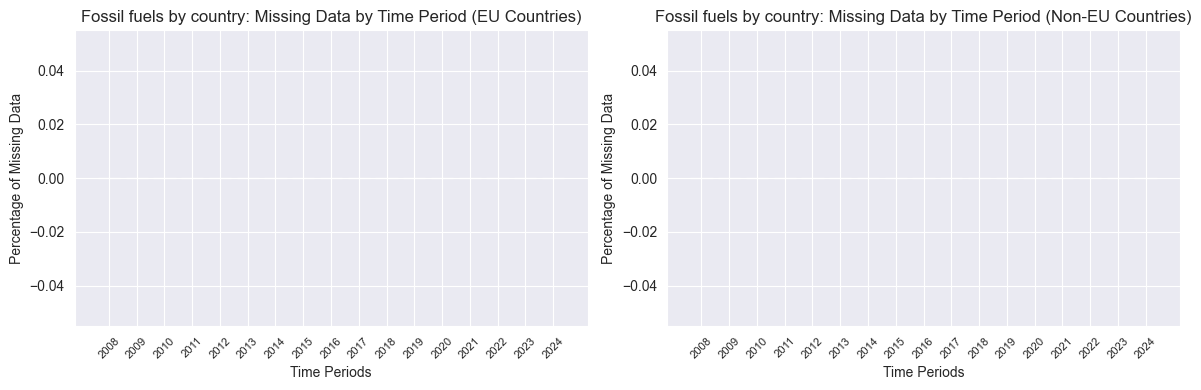

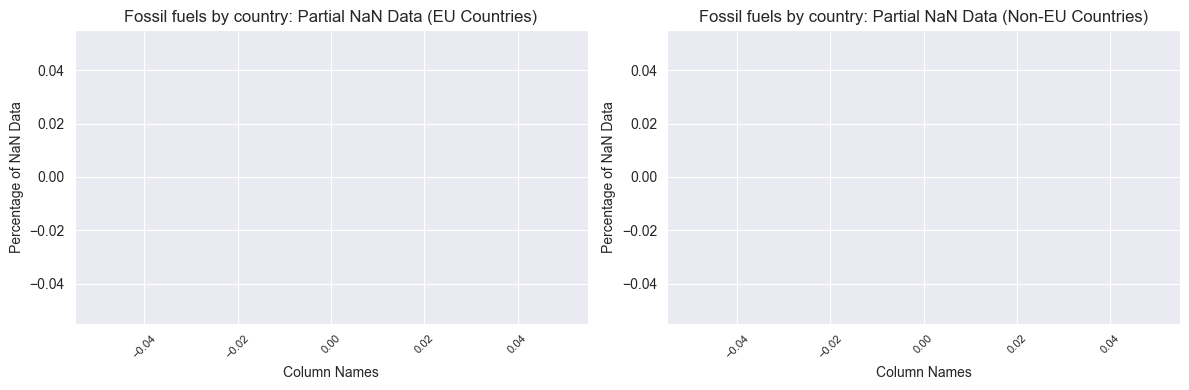

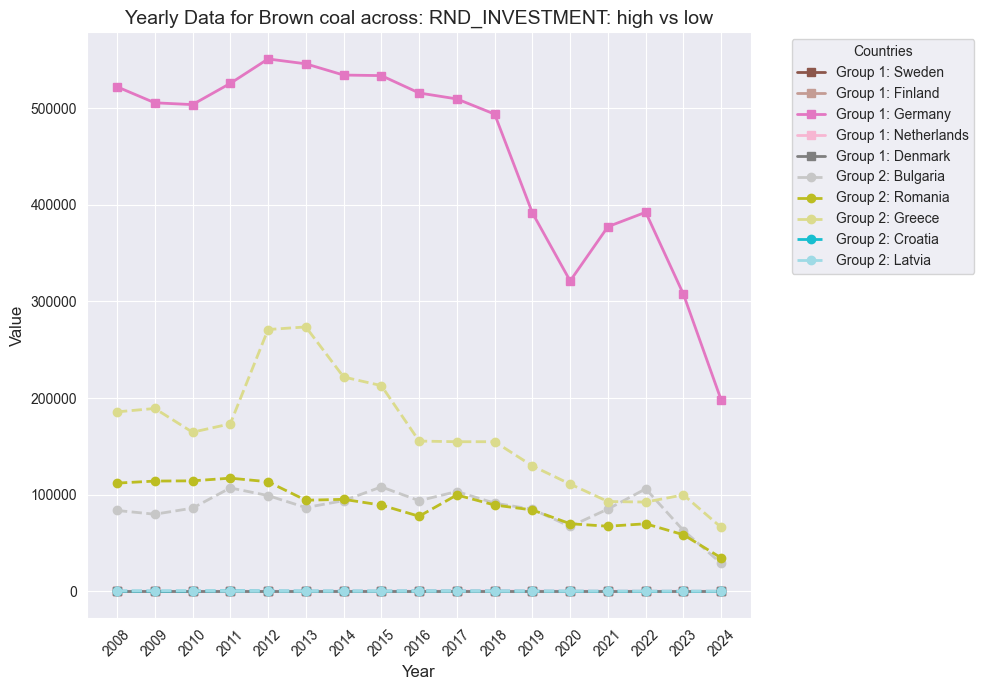

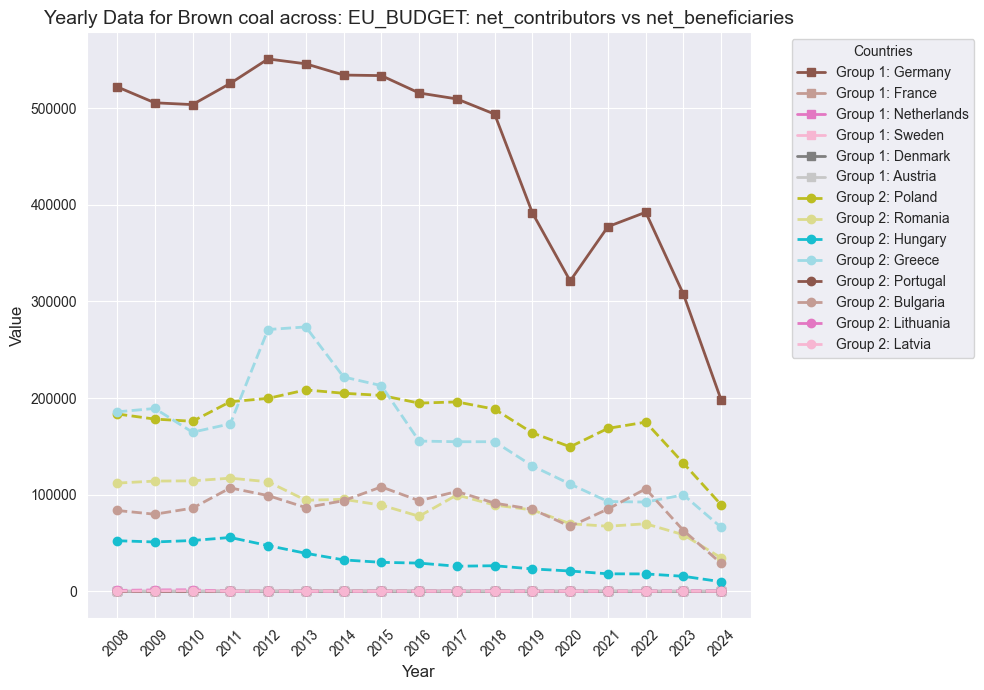

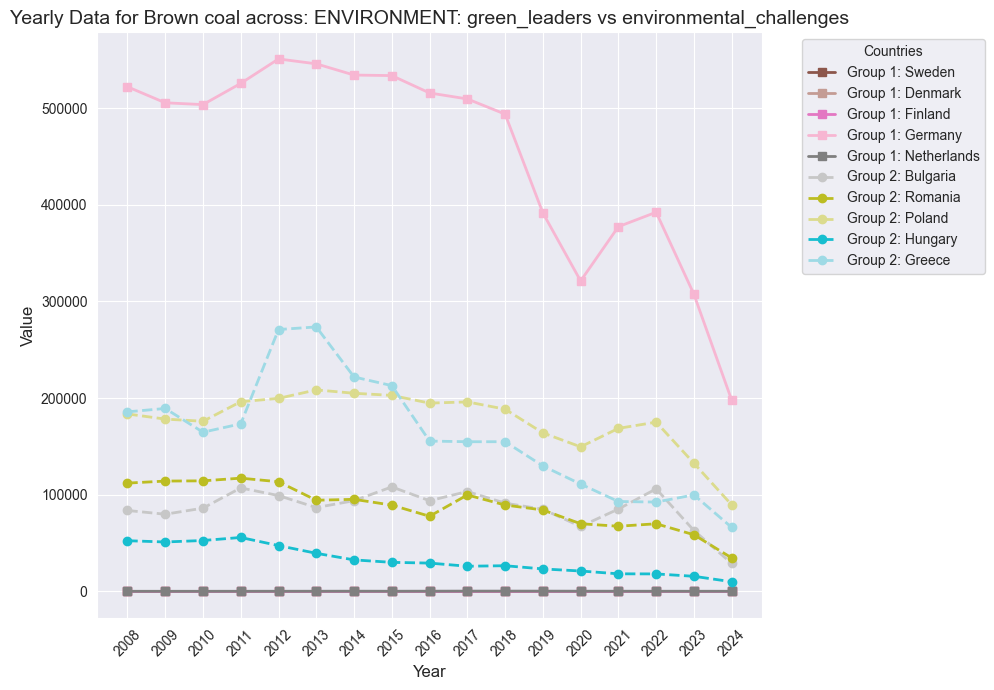

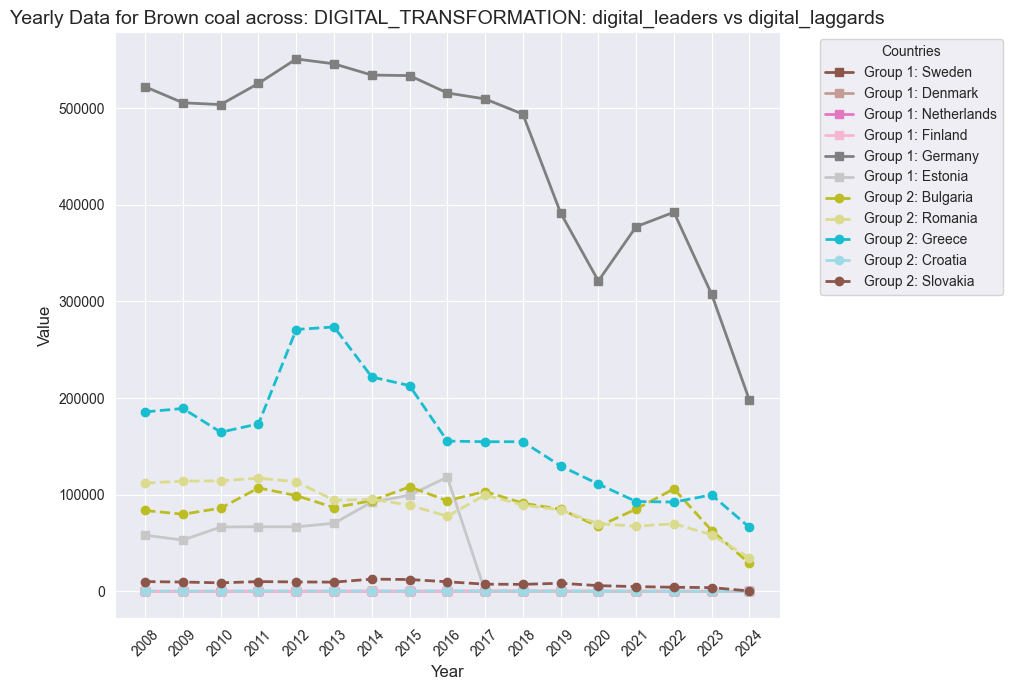

In [150]:
analyze_dataframe(df_fossil_fuels, label_df_fossil_fuels)
plot_comparison_groups(df_fossil_fuels, 'energy_product', 'Brown coal')

### Dataset 4: Share of energy from renewable sources

**Unit of measure**: Percentage

**Available years in the data**: 2004-2023

**Time**: Annually

**Multi-level index**:

* Country
* Energy balance, either:
    * Renewable energy sources
    * Renewable energy sources in electricity
    * Renewable energy sources in heating and cooling
    * Renewable energy sources in transport

**Available flags**:

* ':' : not available


In [151]:
df_share_of_renewable_sources = eurostat_dataset(NRG_IND_REN)
label_df_share_of_renewable_sources = 'Share of energy from renewable energy sources'
df_share_of_renewable_sources = df_share_of_renewable_sources.rename_axis(index={'Energy balance': 'energy_balance'})
df_share_of_renewable_sources.head(15)

2004  \
Country                energy_balance                                            
Albania                Renewable energy sources                          29.62   
                       Renewable energy sources in electricity          69.979   
                       Renewable energy sources in heating and cooling  33.138   
                       Renewable energy sources in transport             0.099   
Austria                Renewable energy sources                         22.553   
                       Renewable energy sources in electricity          61.627   
                       Renewable energy sources in heating and cooling  20.165   
                       Renewable energy sources in transport             4.532   
Belgium                Renewable energy sources                          1.916   
                       Renewable energy sources in electricity           1.714   
                       Renewable energy sources in heating and cooling   2.927   
                       Renewable energy sources in transport             0.642   
Bosnia and Herzegovina Renewable energy sources                            NaN   
                       Renewable energy sources in electricity             NaN   
                       Renewable energy sources in heating and cooling     NaN   

                                                                          2005  \
Country                energy_balance                                            
Albania                Renewable energy sources                         31.367   
                       Renewable energy sources in electricity          76.112   
                       Renewable energy sources in heating and cooling  37.757   
                       Renewable energy sources in transport             0.095   
Austria                Renewable energy sources                         24.353   
                       Renewable energy sources in electricity          62.901   
                       Renewable energy sources in heating and cooling  22.817   
                       Renewable energy sources in transport             5.070   
Belgium                Renewable energy sources                          2.325   
                       Renewable energy sources in electricity           2.386   
                       Renewable energy sources in heating and cooling   3.418   
                       Renewable energy sources in transport             0.663   
Bosnia and Herzegovina Renewable energy sources                            NaN   
                       Renewable energy sources in electricity             NaN   
                       Renewable energy sources in heating and cooling     NaN   

                                                                          2006  \
Country                energy_balance                                            
Albania                Renewable energy sources                         32.070   
                       Renewable energy sources in electricity          74.208   
                       Renewable energy sources in heating and cooling  30.964   
                       Renewable energy sources in transport             0.000   
Austria                Renewable energy sources                         26.276   
                       Renewable energy sources in electricity          63.527   
                       Renewable energy sources in heating and cooling  24.491   
                       Renewable energy sources in transport             7.532   
Belgium                Renewable energy sources                          2.658   
                       Renewable energy sources in electricity           3.130   
                       Renewable energy sources in heating and cooling   3.812   
                       Renewable energy sources in transport             0.676   
Bosnia and Herzegovina Renewable energy sources                            NaN   
                       Renewable energy sources in ele

### Running Data Analysis for dataset 'Share of energy from renewable energy sources' ###

  Total columns analyzed: 20
  Columns with at least one NaN value: 19 (95.00%); 2004-2020, 2022-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 20 (100.00%); 2004-2023
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:

Timeframe of the dataframe: 2004 to 2023
All years have significant data.
All countries have significant data.

Countries with partially missing years:
  Bosnia and Herzegovina: 2004-2013, 2022-2023
  Euro area – 20 countries (from 2023): 2004-2020
  Georgia: 2004-2020
  Iceland: 2023
  Kosovo*: 2023
  Montenegro: 2004
  Serbia: 2023
All EU countries are in the dataframe.
Non-EU countries in the dataframe: ['Albania', 'Bosnia and Herzegovina', 'Euro area – 20 countries (from 2023)', 'European Union - 27 countries (from 2020)', 'Georgia', 'Iceland', 'Kosovo*', 'Moldova', 'Montenegro', 'North

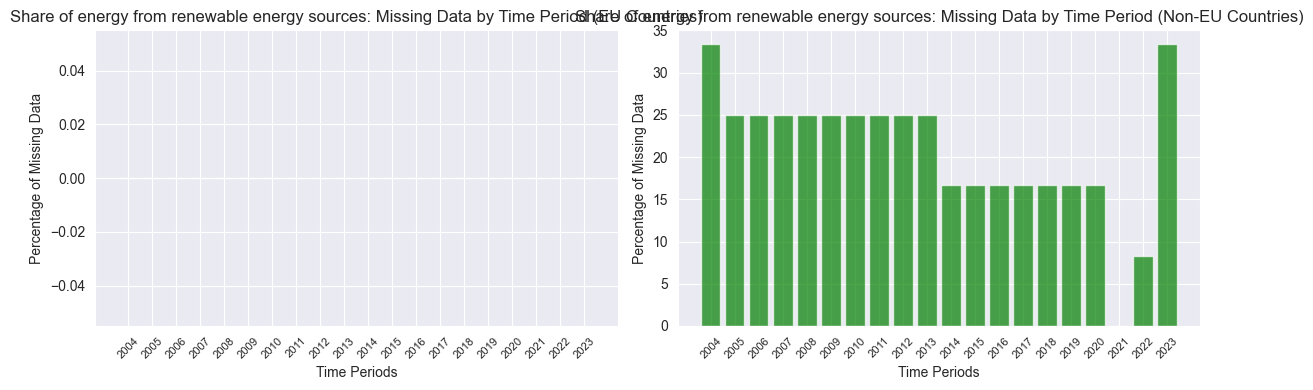

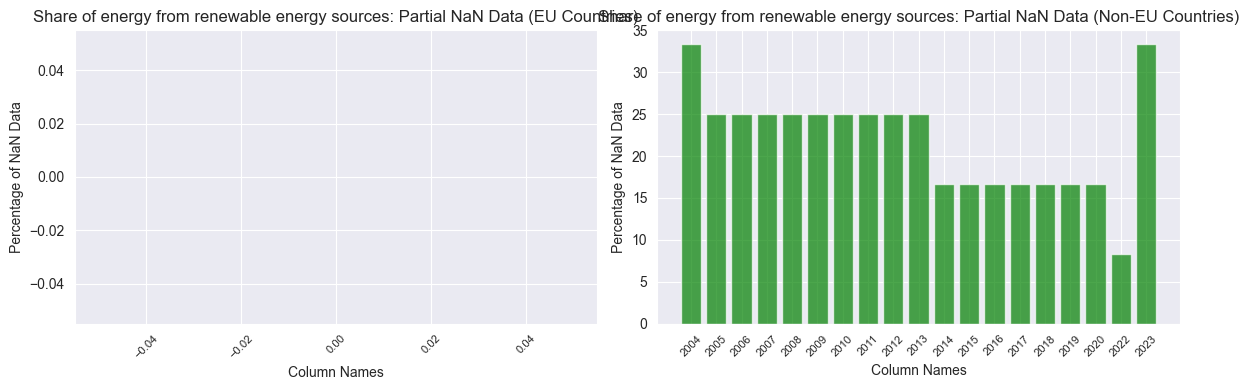

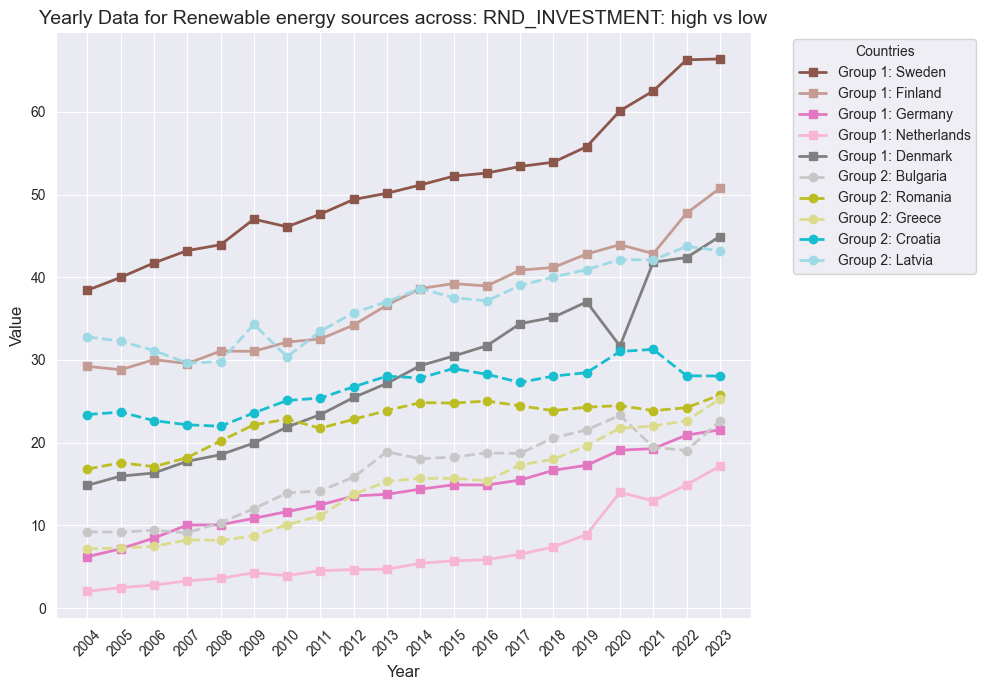

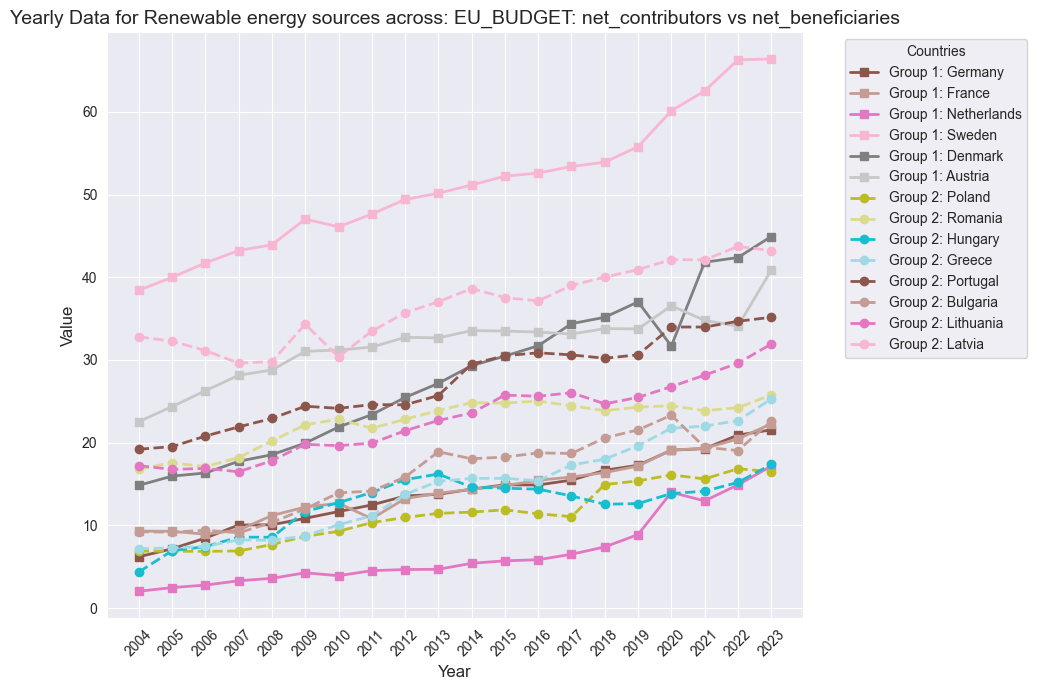

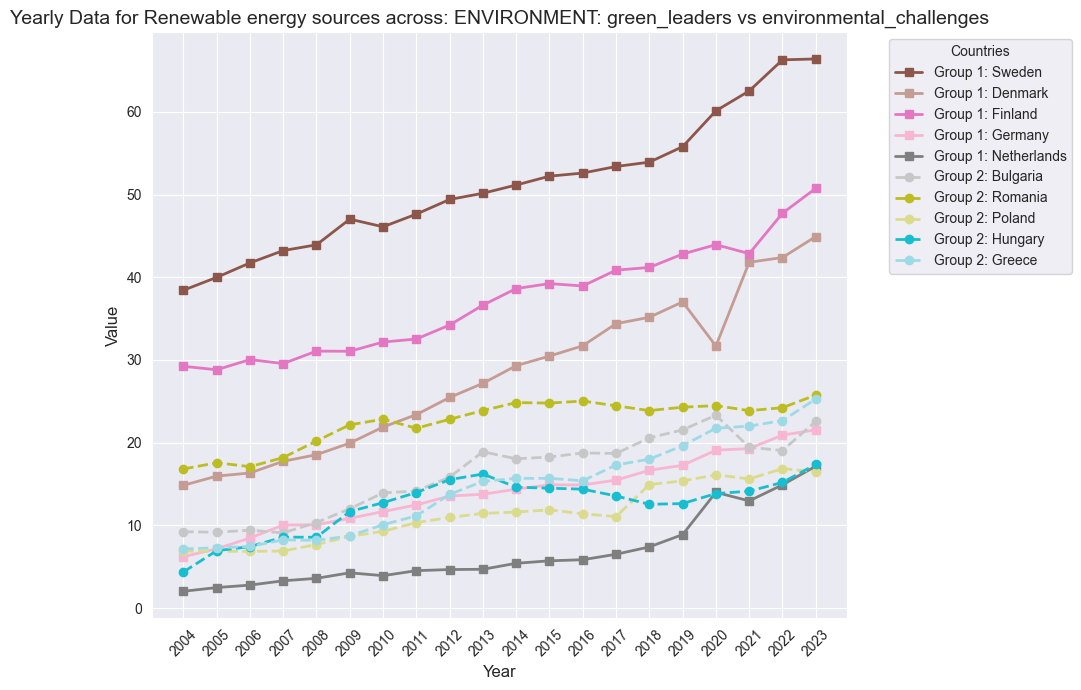

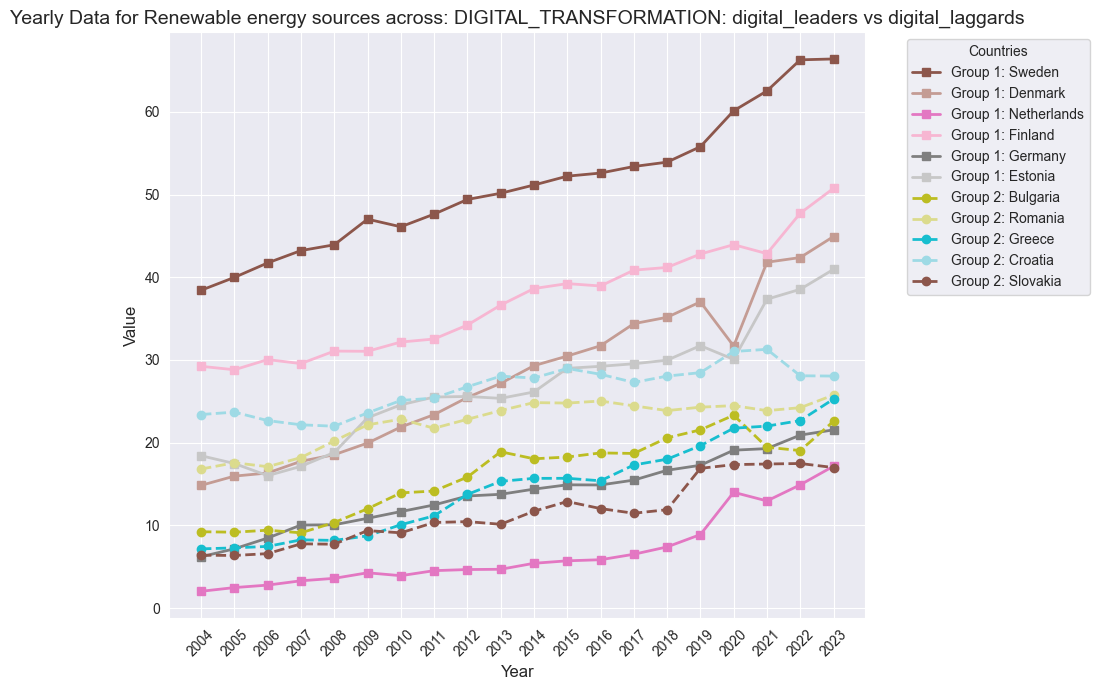

In [152]:
analyze_dataframe(df_share_of_renewable_sources, label_df_share_of_renewable_sources)
plot_comparison_groups(df_share_of_renewable_sources, 'energy_balance', 'Renewable energy sources')

### Dataset 5: Electricity production capacities for renewables and wastes

**Unit of measure**: Megawatt

**Available years in the data**: 1990-2023

**Time**: anually

**Multi-level index**:

* Country

* Energy Product Classification, which can be:
    * Pure hydro power
    * Run-of-river hydro power
    * Mixed hydro power
    * Pumped hydro power
    * Geothermal
    * Wind
    * Wind on shore
    * Wind off shore
    * Solar
    * Solar thermal
    * Solar photovoltaic
    * Solar photovoltaic (< 10 kW)
    * Solar photovoltaic (< 20 kW)
    * Solar photovoltaic (< 30 kW)
    * Solar photovoltaic (< 30 kW, roof top)
    * Solar photovoltaic (< 30 kW, off grid)
    * Solar photovoltaic (20 kW - 1000 kW)
    * Solar photovoltaic (30 kW - 1000 kW)
    * Solar photovoltaic (30 kW - 1000 kW, roof top)
    * Solar photovoltaic (30 kW - 1000 kW, Off grid)
    * Solar photovoltaic (1+ MW)
    * Solar photovoltaic (1+ MW, roof top)
    * Solar photovoltaic (1+ MW, off grid)
    * Solar photovoltaic (off grid)
    * Tide, wave, ocean
    * Solid biofuels
    * Pure biogasoline
    * Pure biodiesels
    * Other liquid biofuels
    * Biogases
    * Waste
    * Industrial waste (non-renewable)
    * Municipal waste

* Technical characteristics of plants, which can be:
    * Net maximum electrical capacity
    * Net maximum electrical capacity - alternating current
    * Net maximum electrical capacity - direct current

**Available flags**:

* ':' : not available

**NOTE**: in this dataset, there is definitely a difference between 0 and NaN!

In general, for this dataset, there are a lot of 0 (probably meaning a 'real' 0), and a lot of NaN's. Especially for the NaN's, which are unlike in the earlier datasets not only for the non-EU countries but also for the EU countries, one should think of a strategy on how to handle those NaNs. TODO how do we proceed?

In [153]:
df_energy_products = eurostat_dataset(NRG_INF_EPCRW)
label_df_energy_products = 'Energy products and technical characteristics of plants by country'
df_energy_products = df_energy_products.rename_axis(index={'Standard international energy product classification (SIEC)': 'energy_product'})
df_energy_products = df_energy_products.rename_axis(index={'Technical characteristics of plants': 'technical_characteristics_of_plants'})
df_energy_products.head(15)

1990  \
Country energy_product                   technical_characteristics_of_plants                        
Albania Biogases                         Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Geothermal                       Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Hydro                            Net maximum electrical capacity                     1453   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Industrial waste (non-renewable) Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   
        Mixed hydro power                Net maximum electrical capacity                        0   
                                         Net maximum electrical capacity - alternating c...   NaN   
                                         Net maximum electrical capacity - direct current     NaN   

                                                                                               1991  \
Country energy_product                   technical_characteristics_of_plants                          
Albania Biogases                         Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Geothermal                       Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Hydro                            Net maximum electrical capacity                     1453.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Industrial waste (non-renewable) Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Mixed hydro power                Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   

                                                                                               1992  \
Country energy_product                   technical_characteristics_of_plants                          
Albania Biogases                         Net maximum electrical capacity                        0.0   
                                         Net maximum electrical capacity - alternating c...     NaN   
                                         Net maximum electrical capacity - direct current       NaN   
        Geothermal                       Net maximum electrical capacity                        0.0   
     

### Running Data Analysis for dataset 'Energy products and technical characteristics of plants by country' ###

  Total columns analyzed: 34
  Columns with at least one NaN value: 34 (100.00%); 1990-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 34 (100.00%); 1990-2023
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
    1990: 74.33%
    1991: 74.33%
    1992: 73.69%
    1993: 73.69%
    1994: 73.69%
    1995: 73.69%
    1996: 73.69%
    1997: 73.69%
    1998: 73.69%
    1999: 73.69%
    2000: 73.12%
    2001: 73.12%
    2002: 73.12%
    2003: 73.12%
    2004: 72.34%
    2005: 69.97%
    2006: 69.97%
    2007: 69.33%
    2008: 69.72%
    2009: 68.74%
    2010: 66.51%
    2011: 65.89%
    2012: 65.25%
    2013: 65.07%
    2014: 62.65%
    2015: 62.04%
    2016: 61.40%
    2017: 60.76%
    2018: 59.48%
    2019: 59.53%
    2020: 59.39%
    2021: 56.73%
    2022: 52.39%
    2023: 69.79%
  Columns with >50% 0 values:

Timefram

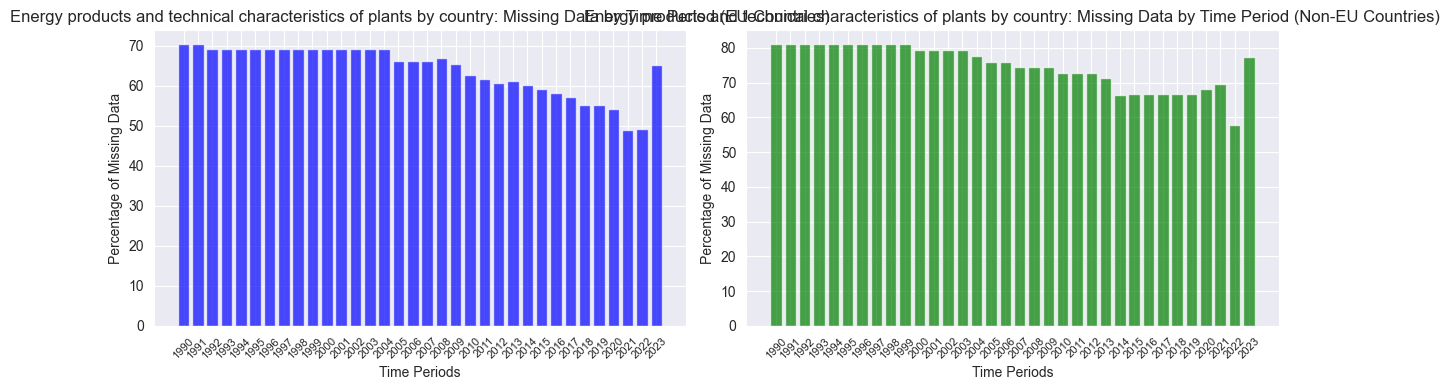

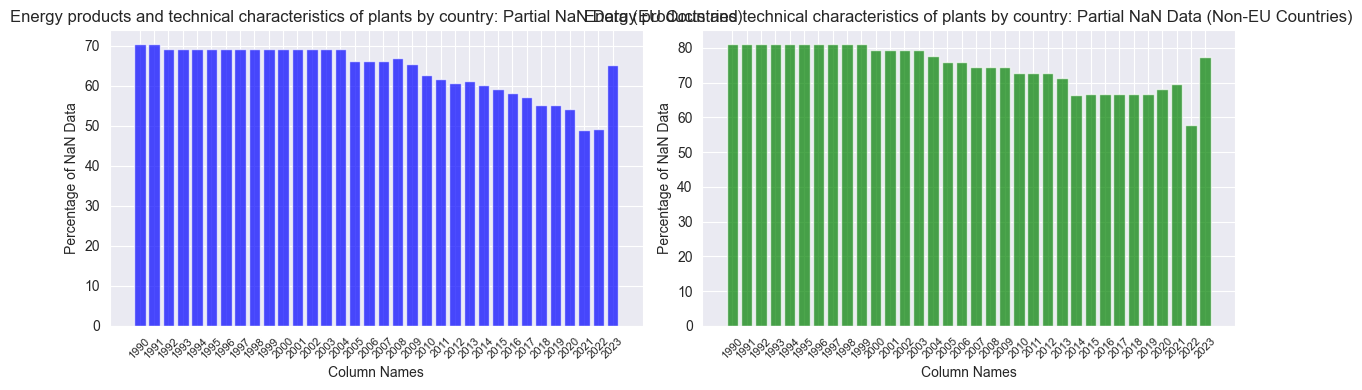

In [154]:
analyze_dataframe(df_energy_products, label_df_energy_products)

### Dataset 6: Electricity prices for household consumers - bi-annual data (from 2007 onwards)

**Unit of measure**: Kilowatt-Hour

**Available years in the data**: 2007 - first half of 2024

**Time**: half-yearly (will be aggregated to annually)

**Multi-level index**:

* Country
* energy_consumption, which can be:
    * Consumption of kWh - all bands
    * Consumption less than 1 000 kWh - band DA
    * Consumption from 1 000 kWh to 2 499 kWh - band DB
    * Consumption from 2 500 kWh to 4 999 kWh - band DC
    * Consumption from 5 000 kWh to 14 999 kWh - band DD
    * Consumption for 15 000 kWh or over - band DE
* taxes, which can be:
    * Excluding taxes and levies
    * All taxes and levies included
    * Excluding VAT and other recoverable taxes and levies
* currency, which can be:
    * Euro
    * Purchasing Power Standard
    * National currency

**Available flags**:

* ':' : not available

In [155]:
df_electricity_prices_semesterly = eurostat_dataset(NRG_PC_204)
df_electricity_prices_semesterly = df_electricity_prices_semesterly.rename_axis(index={'Energy consumption': 'energy_consumption'})
df_electricity_prices_semesterly = df_electricity_prices_semesterly.rename_axis(index={'Taxes': 'taxes'})
df_electricity_prices_semesterly = df_electricity_prices_semesterly.rename_axis(index={'Currency': 'currency'})
df_electricity_prices_semesterly = df_electricity_prices_semesterly.reset_index().drop(columns=['Products']).set_index(['Country', 'energy_consumption', 'taxes', 'currency'])
df_electricity_prices = transform_df_from_semesterly_to_yearly(df_electricity_prices_semesterly)
label_df_electricity_prices = 'Electricity prices by country'
df_electricity_prices.head(15)

2007  \
Country energy_consumption                                taxes                                              currency                         
Albania Consumption for 15 000 kWh or over - band DE      All taxes and levies included                      Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
                                                          Excluding VAT and other recoverable taxes and l... Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
                                                          Excluding taxes and levies                         Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
        Consumption from 1 000 kWh to 2 499 kWh - band DB All taxes and levies included                      Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   
                                                          Excluding VAT and other recoverable taxes and l... Euro                         0   
                                                                                                             National currency            0   
                                                                                                             Purchasing Power Standard    0   

                                                                                                                                        2008  \
Country energy_consumption                                taxes                                              currency                          
Albania Consumption for 15 000 kWh or over - band DE      All taxes and levies included                      Euro                        0.0   
                                                                                                             National currency           0.0   
                                                                                                             Purchasing Power Standard   0.0   
                                                          Excluding VAT and other recoverable taxes and l... Euro                        0.0   
                                                                                                             National currency           0.0   
                                                                                                             Purchasing Power Standard   0.0   
                                                          Excluding taxes and levies                         Euro                        0.0   
                                                                                                             National currency           0.0   
                                                                                                             Purchasing Power Standard   0.0   
        Consumption from 1 000 kWh to 2 499 kWh - band DB All taxes and levies included                      Euro      

### Running Data Analysis for dataset 'Electricity prices by country' ###

  Total columns analyzed: 18
  Columns with at least one NaN value: 0 (0.00%); 
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 18 (100.00%); 2007-2024
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:

Timeframe of the dataframe: 2007 to 2024
All years have significant data.
All countries have significant data.

Countries with partially missing years:
  Albania: 2007-2010
  Bosnia and Herzegovina: 2007-2009
  Georgia: 2007-2017
  Iceland: 2007-2011
  Italy: 2007
  Kosovo*: 2007-2012
  Liechtenstein: 2007-2013
  Moldova: 2007-2014
  Montenegro: 2007-2010
  North Macedonia: 2007-2011
  Serbia: 2007-2012
  Ukraine: 2007-2015, 2022-2024
  United Kingdom: 2021-2024
All EU countries are in the dataframe.
Non-EU countries in the dataframe: ['Albania', 'Bosnia and Herzegovina', 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, 

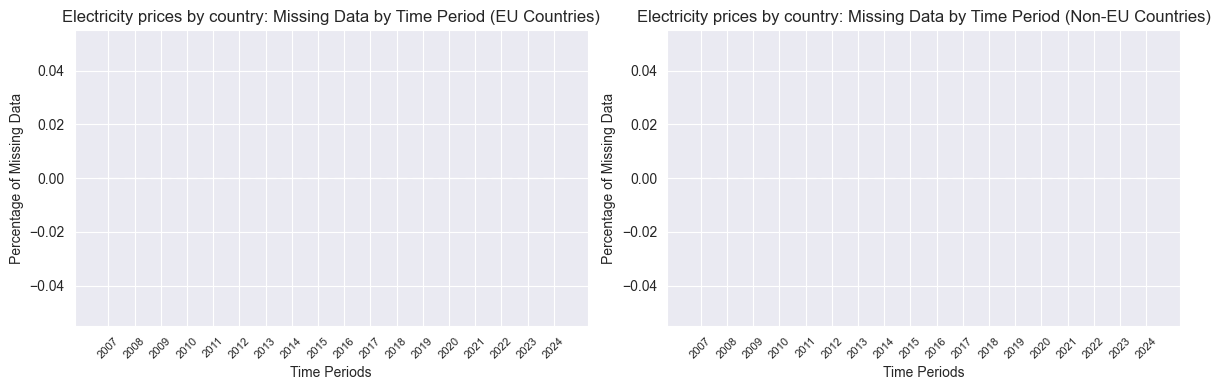

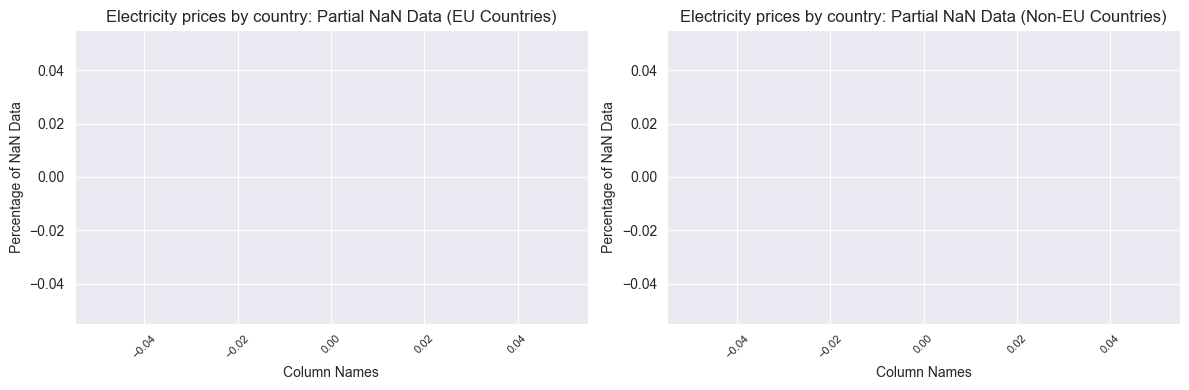

In [156]:
analyze_dataframe(df_electricity_prices, label_df_electricity_prices)

### Dataset 7: Gross domestic product at market prices

**Unit of measure**: Current prices, euro per capita

**Available years in the data**: 2012-2023

**Time**: annually

**Index**:

* Country

**Available flags**:

* ':' : not available
* b : break in time series
* e : estimated
* p : provisional

In [157]:
df_gdp_at_markt_prices = eurostat_dataset(TEC00001)
label_df_gdp_at_markt_prices = 'GDP at markt prices'
df_gdp_at_markt_prices = df_gdp_at_markt_prices.reset_index().drop(columns=['National accounts indicator (ESA 2010)']).set_index(['Country'])
df_gdp_at_markt_prices.head(15)

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Country,,,,,,,,,,,,
Albania,3300,3320.0,3450.0,3560.0,3730.0,4020.0,4480.0,4880.0,4710.0,5420.0,6500.0,NaN
Austria,37570,37890.0,38640.0,39640.0,40690.0,41760.0,43360.0,44570.0,42650.0,45380.0,49490.0,51830.0
Belgium,34930,35360.0,36130.0,36860.0,37810.0,38980.0,40210.0,41730.0,40190.0,43670.0,48250.0,50620.0
Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulgaria,5820,5870.0,6080.0,6560.0,7070.0,7720.0,8360.0,9270.0,9450.0,10970.0,13310.0,14690.0
Croatia,10510,10530.0,10450.0,10810.0,11400.0,12160.0,12960.0,13990.0,12840.0,14890.0,17260.0,19800.0
Cyprus,22570,20930.0,20510.0,21220.0,22330.0,23630.0,25060.0,26530.0,25080.0,28520.0,32230.0,33800.0
Czechia,15590,15280.0,15140.0,16230.0,17040.0,18700.0,20270.0,21740.0,20980.0,23430.0,26670.0,29180.0
Denmark,45490,46240.0,47070.0,47900.0,49270.0,51060.0,51950.0,53040.0,53540.0,58970.0,64730.0,63290.0


### Running Data Analysis for dataset 'GDP at markt prices' ###

  Total columns analyzed: 12
  Columns with at least one NaN value: 12 (100.00%); 2012-2023
  Columns with only NaN values: 0 (0.00%); 
  Columns with at least one 0 value: 0 (0.00%); 
  Columns with only 0 values: 0 (0.00%); 
  Columns with >50% NaN values:
  Columns with >50% 0 values:

Timeframe of the dataframe: 2012 to 2023
All years have significant data.
Countries with near-zero values in all years: ['Bosnia and Herzegovina', 'Kosovo*']

Countries with partially missing years:
  Albania: 2023
  Liechtenstein: 2012, 2023
  United Kingdom: 2020-2023
All EU countries are in the dataframe.
Non-EU countries in the dataframe: ['Albania', 'Bosnia and Herzegovina', 'Euro area - 19 countries  (2015-2022)', 'Euro area – 20 countries (from 2023)', 'European Union - 27 countries (from 2020)', 'Iceland', 'Kosovo*', 'Liechtenstein', 'Montenegro', 'North Macedonia', 'Norway', 'Serbia', 'Switzerland', 'Türkiye', 'United Kingdom']


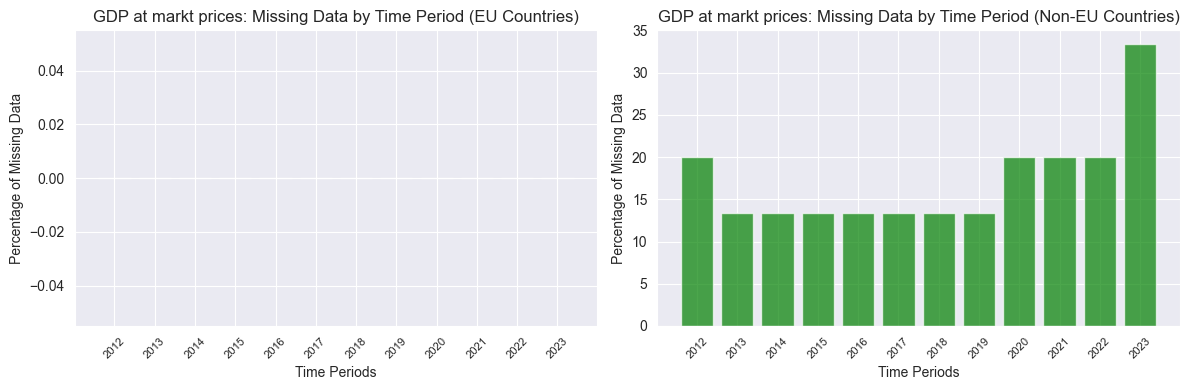

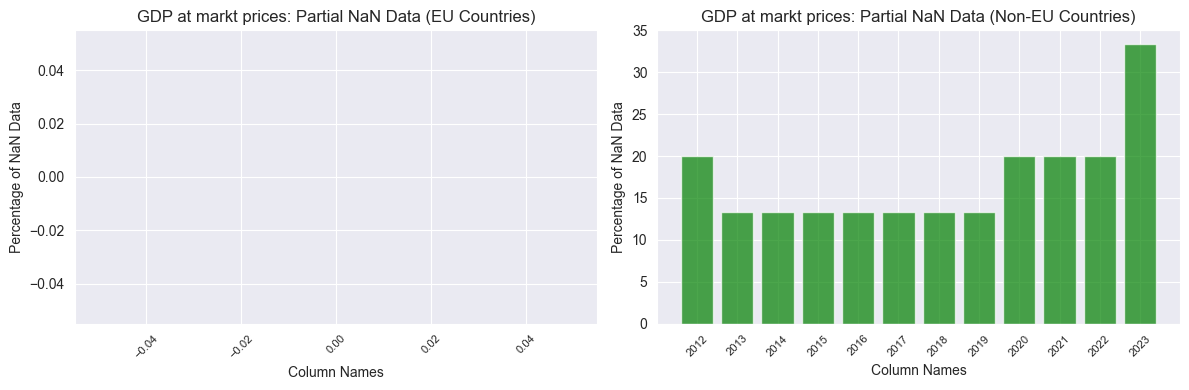

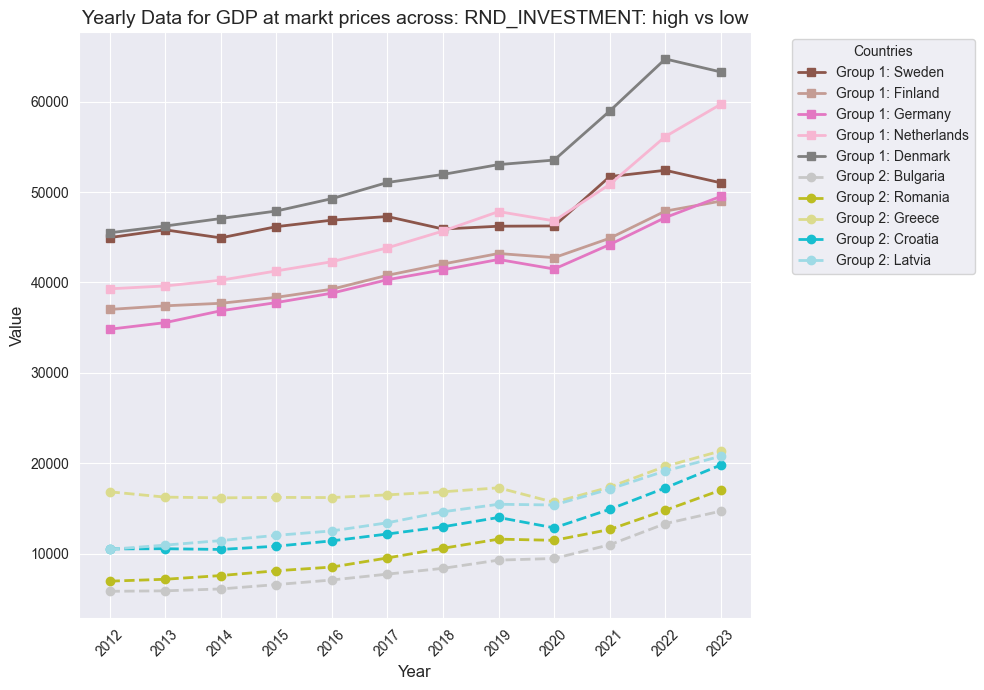

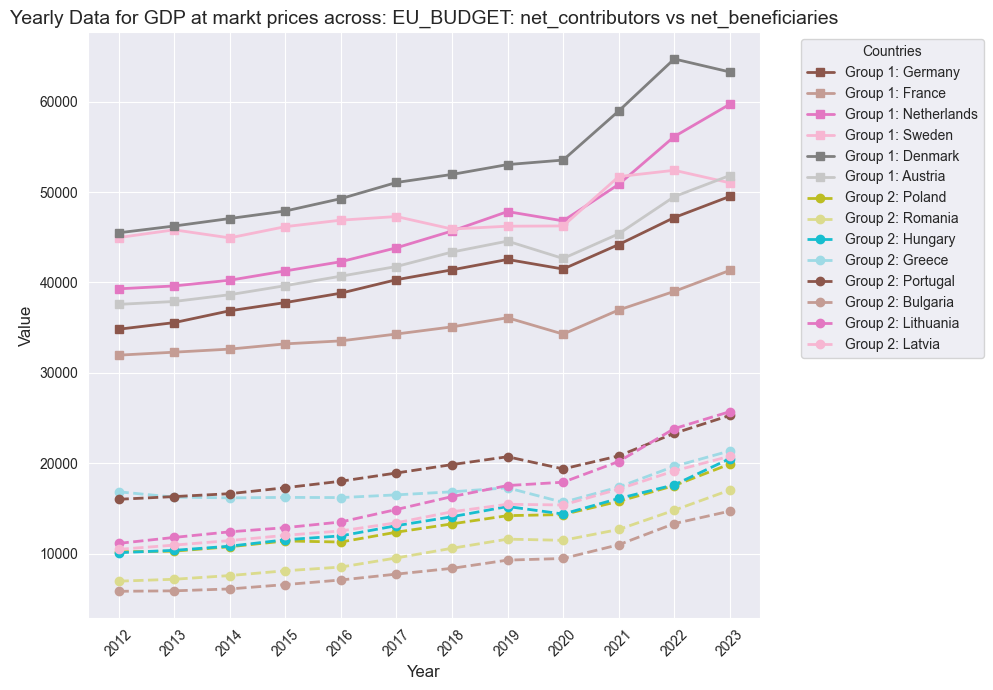

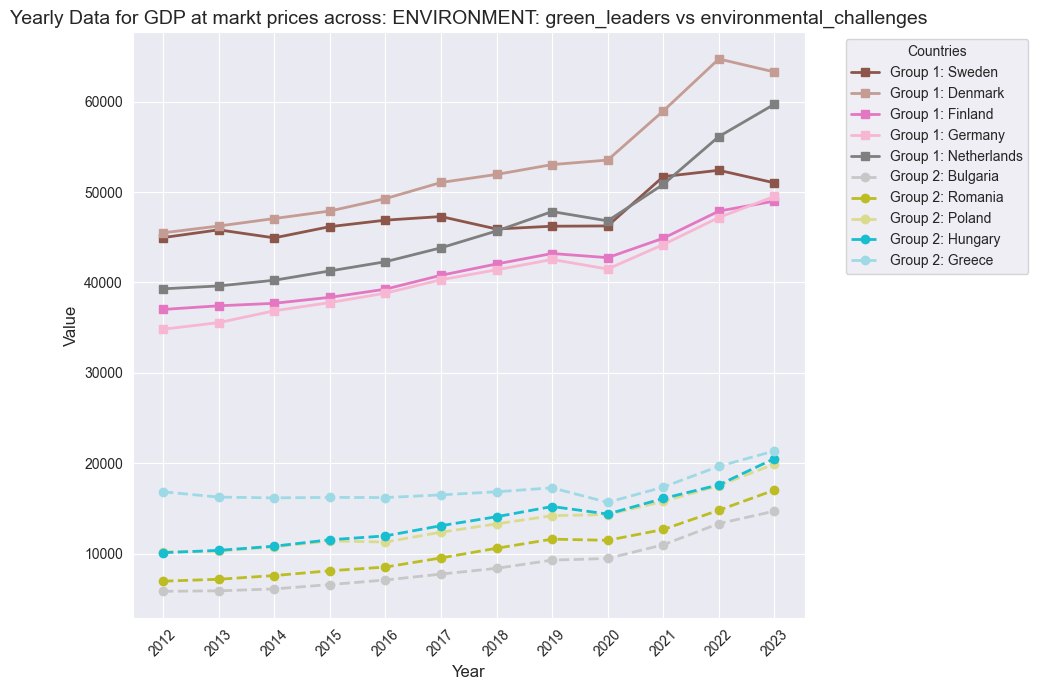

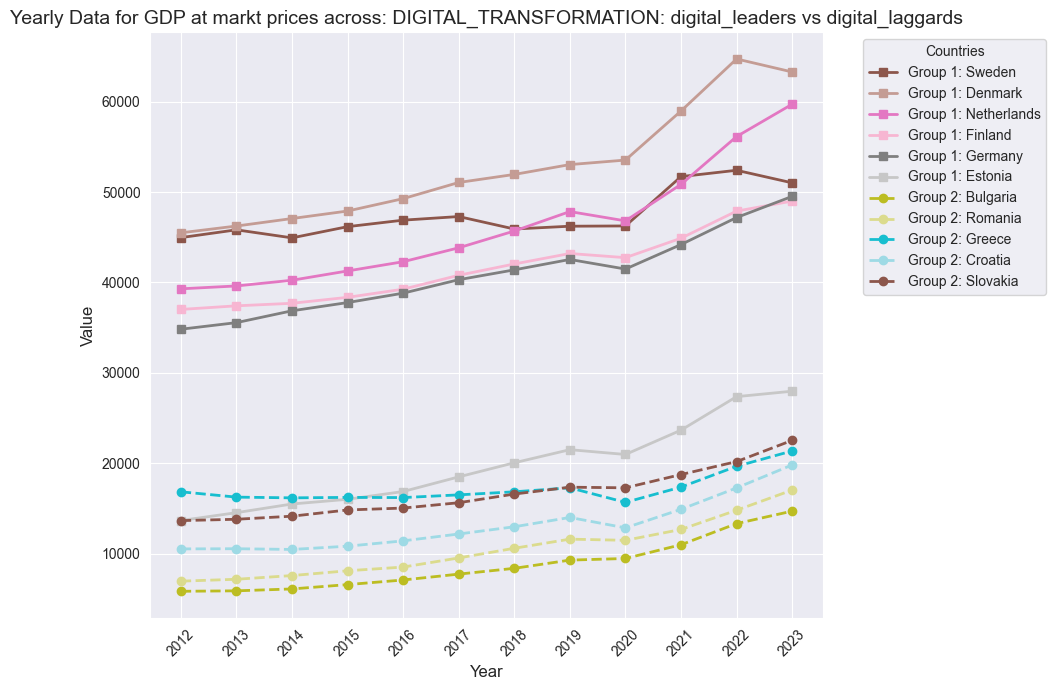

In [158]:
analyze_dataframe(df_gdp_at_markt_prices, label_df_gdp_at_markt_prices)
plot_comparison_groups(df_gdp_at_markt_prices, None, 'GDP at markt prices')

## Missing data

### Reasons for missing data

TODO document reasons for missing data and how to deal with that.

1. **no data available before a given threshold**
   can be the case if the given data was not collected by the government until some time
2. **other reasons**
   Placeholder for all missing data where we cannot find a direct pattern/reason

## Question 1: How is the adoption of renewable energy in Europe evolving?

In [159]:
# TODO this dataset was already read in and transformed in the section above; adjust code to this existing dataframe
energy_share = eurostat_dataset(NRG_IND_REN)

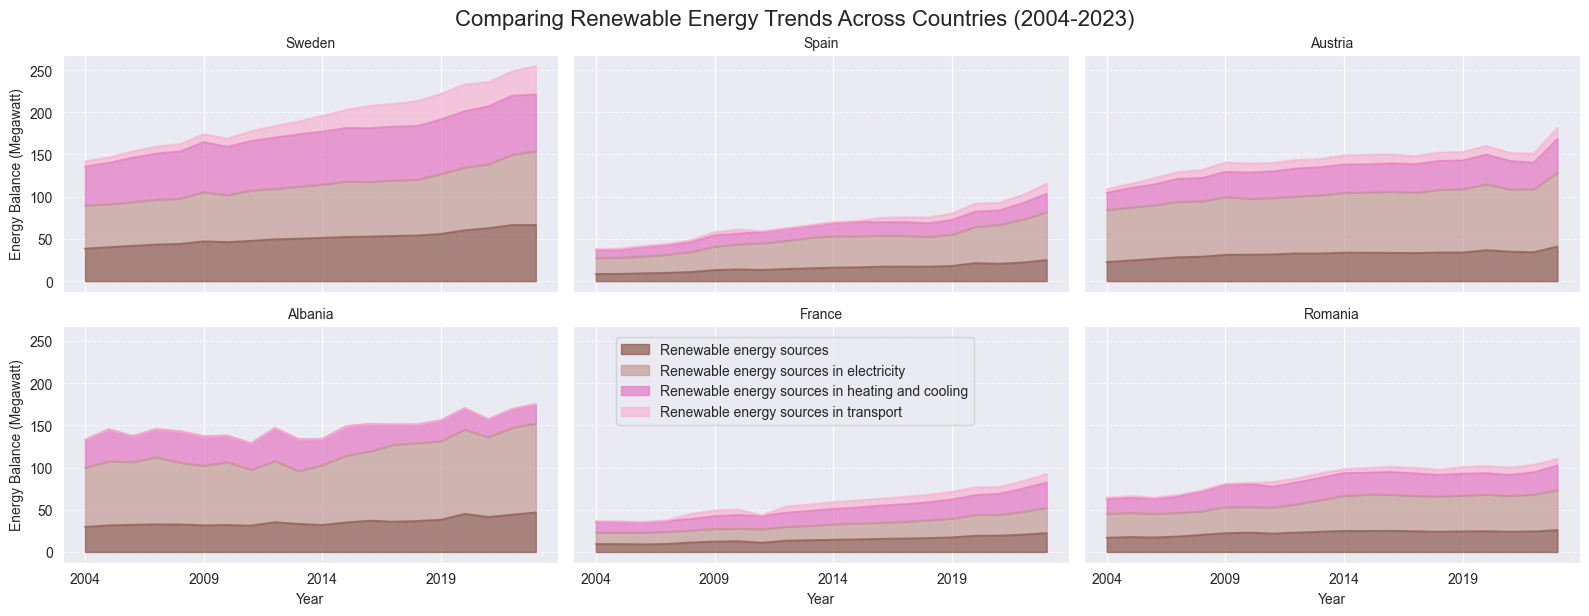

In [160]:
# Select a subset of countries for comparison
countries_to_compare = ("Sweden", "Spain", "Austria", "Albania", "France", "Romania")
comparison_data = energy_share.loc[energy_share.index.get_level_values('Country').isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_title(country, fontsize=10)
    axes[idx].set_xlabel("Year", fontsize=10)
    axes[idx].set_ylabel("Energy Balance (Megawatt)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.4), ncol=1, fontsize=10)

plt.tight_layout()
plt.suptitle("Comparing Renewable Energy Trends Across Countries (2004-2023)", fontsize=16, y=1.02)
plt.show()

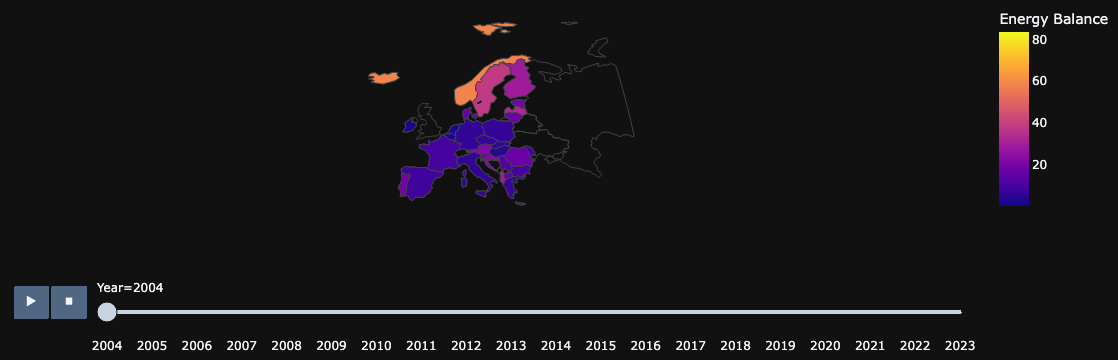

In [161]:
melted_data = energy_share.reset_index().melt(id_vars=["Country", "Energy balance"], var_name="Year", value_name="Energy Balance")

renewable_data = melted_data[melted_data["Energy balance"] == "Renewable energy sources"].copy()
renewable_data["Year"] = renewable_data["Year"]
renewable_data["Energy Balance"] = renewable_data["Energy Balance"].infer_objects()

fig = px.choropleth(
    renewable_data,
    range_color=(renewable_data['Energy Balance'].min(), renewable_data['Energy Balance'].max()),
    locations="Country",
    locationmode="country names",
    color="Energy Balance",
    projection="natural earth",
    hover_name="Country",
    animation_frame="Year",
    # title="Renewable Energy Trends Across the EU (2004-2023)",
    scope="europe"
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Question 2: How is the adoption of different types of renewable energy evolving?

In [2]:

# Select a subset of countries for comparison
energy_share = eurostat_dataset(NRG_IND_REN)
countries_to_compare = ("Sweden", "Spain", "Austria", "Albania", "France", "Romania")
comparison_data = energy_share.loc[energy_share.index.get_level_values('Country').isin(countries_to_compare)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(countries_to_compare):
    country_data = comparison_data.loc[country]
    
    country_data.T.plot(kind='area', stacked=True, alpha=0.7, ax=axes[idx], legend=False)
    
    axes[idx].set_title(country, fontsize=10)
    axes[idx].set_xlabel("Year", fontsize=10)
    axes[idx].set_ylabel("Energy Balance (Megawatt)", fontsize=10)
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, 0.4), ncol=1, fontsize=10)

plt.tight_layout()
plt.suptitle("Comparing Renewable Energy Trends Across Countries (2004-2023)", fontsize=16, y=1.02)
plt.show()

NameError: name 'eurostat_dataset' is not defined

## Question 3: Are there characteristics of countries that correlate with their level of adoption of renewable energy?

In [163]:
# TODO: work on it